In [1]:
%xmode verbose

Exception reporting mode: Verbose


In [2]:
!pip install statsforecast -q
!pip install neuralforecast -q
!pip install datasetsforecast -q
!pip install darts -q
!pip install sktime==0.17.0 -q
!pip install pycaret -q
# !pip install prophet -q
# !pip install MissForest -q
# !pip install pycaret -q

# !pip install pytest -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires statsmodels<0.14,>=0.13.2, but you have statsmodels 0.14.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
ydata-profiling 4.1.2 requires statsmodels<0.14,>=0.13.2, but you have statsmodels 0.14.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


# Faktor yang mempengaruhi Data Emas

In Indonesia, the factors that can impact the gold price are:

1. Supply and demand: The relationship between the supply of and demand for gold is a key factor affecting its price.
2. Economic conditions: Economic conditions in Indonesia, such as inflation, recession, and interest rates, can affect the demand for gold and thus its price.
3. Political stability: Political stability and uncertainty in Indonesia can impact the demand for gold as a safe haven asset and thereby affect its price.
4. Currency fluctuations: Changes in the value of the Indonesian Rupiah against other major currencies can impact the price of gold.
5. Mining and production costs: The cost of mining and producing gold in Indonesia can impact its price.
6. Jewelry demand: The demand for gold in the jewelry industry can impact its price.
7. Technology demand: The demand for gold in technology applications can impact its price.
8. Central bank buying and selling: Central bank activities, such as buying and selling gold, can impact its price.

Reference:

KPMG. (2018). The gold market: A review of the supply chain, demand, and pricing. In KPMG International (Ed.), Global Precious Metals Handbook 2018 (pp. 12-24). KPMG International.
Torgler, B. (2017). Gold demand, supply, and price dynamics: A macroeconomic analysis. In Gold Demand, Supply and Price Dynamics (pp. 1-23). Emerald Publishing Limited.
Buiter, W. H. (2012). The economics of gold. Handbook of Commodity Markets and Investment (pp. 557-592). Springer.

# Persiapan Dataset

In [3]:
from prophet import Prophet
from statsmodels.tsa.stattools import grangercausalitytests
from statsforecast.adapters.prophet import AutoARIMAProphet

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
import seaborn as sns

from sktime.transformations.panel.tsfresh import (
    TSFreshRelevantFeatureExtractor,
    TSFreshFeatureExtractor
)
from sktime.transformations.panel.catch22 import Catch22

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
%matplotlib inline

In [5]:
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('pystan').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('statsmodels').setLevel(logging.CRITICAL)

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.base.model")
warnings.filterwarnings("ignore")

## Fungsi Tambahan

In [6]:
import numpy as np
from scipy import stats

def stable_seasonality_test(data, period):
    """
    Perform the Stable Seasonality Test on a time series.
    
    Parameters:
    data (array-like): The time series data.
    period (int): The number of periods in the time series (e.g., 12 for monthly data).
    
    Returns:
    F (float): The F-statistic for the test.
    p (float): The p-value for the test.
    """
    # Compute the seasonal index ratios
    si_ratios = np.zeros(period)
    for i in range(period):
        si_ratios[i] = np.mean(data[i::period])
    si_ratios /= np.mean(si_ratios)
    
    # Detrend the time series
    detrended = data - np.mean(data)
    
    # Adjust for prior factors
    adjusted = detrended / np.tile(si_ratios, len(data) // period + 1)[:len(data)]
    
    # Perform one-way ANOVA
    groups = [adjusted[i::period] for i in range(period)]
    F, p = stats.f_oneway(*groups)
    
    return F, p

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot_power_spectrum(data, fs):
    """
    Compute and plot the power spectrum of a time series.
    
    Parameters:
    data (array-like): The time series data.
    fs (float): The sampling frequency of the time series.
    """
    # Compute the power spectrum
    f, Pxx = signal.periodogram(data, fs)
    
    # Plot the power spectrum
    plt.semilogy(f, Pxx)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')
    plt.show()

In [8]:
from datasetsforecast.losses import mse, mae, rmse

def eva_cro_val_sf(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [9]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_matrix(data, variables, maxlag, test='ssr_chi2test'):
    """
    This function returns two dataframes with results of granger causality tests for all pairs of variables.
    
    Parameters:
        data (DataFrame): The input data, containing all variables in the form of a time series.
        variables (list): List of all the variables to be tested.
        maxlag (int): Maximum number of lags to test.
        test (str): Test statistic to use (default is 'ssr_chi2test').
    
    Returns:
        tuple: Two dataframes, the first one contains the minimum lags where causality is found, and the second one contains the p-values at those lags.
    """
    num_vars = len(variables) # Number of variables
    df1 = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=[var + "_y" for var in variables], index=[var + "_x" for var in variables])
    df2 = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=[var + "_y" for var in variables], index=[var + "_x" for var in variables])
    
    # Loop through all variable combinations
    for i in range(num_vars):
        for j in range(i+1, num_vars):
            result = None
            try:
                result = grangercausalitytests(data[[variables[i], variables[j]]], maxlag=maxlag, verbose=False)
                p_values = [round(result[lag][0][test][1], 10) for lag in range(1, maxlag+1)]
                min_lag = np.argmin(p_values)
                if min_lag == maxlag - 1 and p_values[min_lag] >= 0.05:
                    df1.loc[variables[i] + '_x', variables[j] + '_y'] = None
                    df2.loc[variables[i] + '_x', variables[j] + '_y'] = None
                else:
                    df1.loc[variables[i] + '_x', variables[j] + '_y'] = int(min_lag+1)
                    df2.loc[variables[i] + '_x', variables[j] + '_y'] = p_values[min_lag]
            except:
                df1.loc[variables[i] + '_x', variables[j] + '_y'] = None
                df2.loc[variables[i] + '_x', variables[j] + '_y'] = None
    return df1.T, df2.T

In [10]:
import statsmodels.api as sm

def make_stationary(data, max_diff = 10):
    """
    This function will return the stationary time series after difference has been applied and the number of differences applied.
    The input data should be a one-dimensional numpy array or pandas series.
    
    Parameters:
    data (numpy array or pandas series): The time series data that needs to be made stationary.
    max_diff (int, optional): The maximum number of differences to be applied. Defaults to 10.
    
    Returns:
    tuple: A tuple contains the stationary time series and the number of differences applied.
    """
    diff = 0
    result = sm.tsa.stattools.adfuller(data)
    while result[1] >= 0.05 and diff < max_diff:
        data = np.diff(data)
        result = sm.tsa.stattools.adfuller(data)
        diff += 1
    return data, diff


In [11]:
import pandas as pd

def date_to_ym(date_series):
    """
    Convert a pandas series of datetime dates into a series of strings in the format "YYYY-MM".
    
    Parameters:
        date_series (pd.Series): A pandas series of datetime dates.
    
    Returns:
        pd.Series: A pandas series of strings in the format "YYYY-MM".
    """
    datetime_series = pd.to_datetime(date_series)
    ym_series = datetime_series.dt.strftime("%Y-%m")
    return ym_series

In [12]:
from datetime import datetime

def indonesian_month_to_date(month_string_year_int):
    month_dict = {
        'Januari': '01',
        'Februari': '02',
        'Maret': '03',
        'April': '04',
        'Mei': '05',
        'Juni': '06',
        'Juli': '07',
        'Agustus': '08',
        'September': '09',
        'Oktober': '10',
        'November': '11',
        'Desember': '12'
    }
    split_string = month_string_year_int.split(" ")
    month = month_dict[split_string[0]]
    year = split_string[1]
    date_str = f"{year}-{month}"
    return date_str

In [13]:
def string_to_date_indo(date_string):
    """
    This function takes a date string in the format "dd month_name yyyy"
    (with support for Indonesian month names) and returns a datetime.date object.
    """
    
    # Dictionary to map Indonesian month names to English month names
    indonesian_months = {
        "Januari": "January",
        "Februari": "February",
        "Maret": "March",
        "April": "April",
        "Mei": "May",
        "Juni": "June",
        "Juli": "July",
        "Agustus": "August",
        "September": "September",
        "Oktober": "October",
        "November": "November",
        "Desember": "December"
    }
    
    # Replace the Indonesian month name in the input date_string with the corresponding English month name
    date_string = date_string.replace(date_string.split(" ")[1], indonesian_months[date_string.split(" ")[1]])
    
    # Parse the input date_string into a datetime.date object
    date_object = datetime.strptime(date_string, "%d %B %Y").date()
    
    # Return the datetime.date object
    return date_object

In [14]:
var_inter_model = {'tanggal':'ds',
                    'harga_emas':'y',
                    'kurs_jual':'kurs_jual',
                    'kurs_beli':'kurs_beli',
                    'data_inflasi':'data_inflasi',
                    'suku_bunga_bi':'suku_bunga_bi'}

var_model_inter = {'ds':'tanggal',
                    'y':'harga_emas',
                    'kurs_jual':'kurs_jual',
                    'kurs_beli':'kurs_beli',
                    'data_inflasi':'data_inflasi',
                    'suku_bunga_bi':'suku_bunga_bi'}

## Data Emas 

In [15]:
import numpy as np
import pandas as pd
from datetime import date, timedelta

## Cara Mendapatkan Data Harga Emas

1. Buka Link [ini](https://www.logammulia.com/id/harga-emas-hari-ini)
2. Buka Browser console
3. Ikutin langkah langkah Berikut ini

   1. Daptakan datanya

      ```javascript
      var obj = Highcharts.charts[0].options.series[0].data;
      ```

   2. Jadikan data tersebut jadi file berbentuk JSON

      ```javascript
      var data = "text/json;charset=utf-8," + encodeURIComponent(JSON.stringify(obj));
      ```

   3. Buatkan Tombol untuk mendownload file tersebut

   ```javascript
   $('<a href="data:' + data + '" download="data.json">download JSON</a>').appendTo("#container");
   ```


In [16]:
from datetime import datetime as dtime


direc = "/kaggle/input/data-emas-skripsi/Data_emas/"

tabel_emas         = pd.read_json(direc + 'data_emas.json')
tabel_emas.columns = ['tanggal','harga_emas']
# tabel_emas.tanggal
tabel_emas.tanggal = pd.to_datetime(tabel_emas.tanggal,unit='ms').dt.date

enddate = pd.to_datetime('2023-05-1').date()
tabel_emas = tabel_emas.loc[tabel_emas.tanggal < enddate]
tabel_emas = tabel_emas.iloc[tabel_emas.tanggal.drop_duplicates().index.tolist(),:]
tabel_emas = tabel_emas.reset_index(drop=True)
tabel_emas.tail(10)

,tanggal,harga_emas
3817,2023-04-14,1084000
3818,2023-04-15,1067000
3819,2023-04-16,1067000
3820,2023-04-17,1066000
3821,2023-04-18,1054000
3822,2023-04-26,1062000
3823,2023-04-27,1062000
3824,2023-04-28,1062000
3825,2023-04-29,1056000
3826,2023-04-30,1056000


In [17]:
full_day = len(pd.date_range(start=tabel_emas.tanggal[0],end=tabel_emas.tanggal[((tabel_emas.shape[0])-1)]))
business_day = tabel_emas.shape[0]

print(f'Seluruh hari dari {tabel_emas.tanggal[0]} - {tabel_emas.tanggal[((tabel_emas.shape[0])-1)]} adalah {full_day}')
print(f'hari bisnis indonesia adalah {business_day}')
print(f'Hari yang kosong adalah {full_day - business_day}')

Seluruh hari dari 2010-01-04 - 2023-04-30 adalah 4865
hari bisnis indonesia adalah 3827
Hari yang kosong adalah 1038


In [18]:
tabel_emas

,tanggal,harga_emas
0,2010-01-04,408000
1,2010-01-05,410000
2,2010-01-06,410000
3,2010-01-07,412000
4,2010-01-08,410000
...,...,...
3822,2023-04-26,1062000
3823,2023-04-27,1062000
3824,2023-04-28,1062000
3825,2023-04-29,1056000


## Data Kurs Dolar Ke Rupiah
* https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/default.aspx


In [19]:
# data 
# https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/default.aspx

data_kurs = pd.read_excel(direc + 'Kurs Transaksi USD.xlsx',skiprows=4)
data_kurs = data_kurs.drop(['NO','Nilai'],axis=1)
data_kurs.Tanggal = pd.to_datetime(data_kurs.Tanggal,format='%m/%d/%Y %I:%M:%S %p')
data_kurs.Tanggal = data_kurs.Tanggal.dt.date
data_kurs.head(20)

,Kurs Jual,Kurs Beli,Tanggal
0,14824.75,14677.25,2023-04-28
1,14956.41,14807.59,2023-04-27
2,14929.27,14780.73,2023-04-26
3,14846.86,14699.14,2023-04-18
4,14739.33,14592.67,2023-04-17
5,14865.96,14718.04,2023-04-14
6,14940.33,14791.67,2023-04-13
7,14962.44,14813.56,2023-04-12
8,14979.52,14830.48,2023-04-11
9,15017.72,14868.28,2023-04-10


In [20]:
data_kurs.tail(20)

,Kurs Jual,Kurs Beli,Tanggal
3259,9412.0,9318.0,2010-01-29
3260,9455.0,9361.0,2010-01-28
3261,9427.0,9333.0,2010-01-27
3262,9362.0,9268.0,2010-01-26
3263,9387.0,9293.0,2010-01-25
3264,9435.0,9341.0,2010-01-22
3265,9366.0,9272.0,2010-01-21
3266,9321.0,9229.0,2010-01-20
3267,9271.0,9179.0,2010-01-19
3268,9276.0,9184.0,2010-01-18


In [21]:
tabel_emas_kurs = pd.merge(tabel_emas, data_kurs,
                           how='left',
                           left_on='tanggal',
                           right_on='Tanggal')
tabel_emas_kurs = tabel_emas_kurs.drop(['Tanggal'],axis=1)
tabel_emas_kurs["month_year"] = date_to_ym(tabel_emas_kurs.tanggal)
tabel_emas_kurs

,tanggal,harga_emas,Kurs Jual,Kurs Beli,month_year
0,2010-01-04,408000,9377.00,9283.00,2010-01
1,2010-01-05,410000,9355.00,9261.00,2010-01
2,2010-01-06,410000,9355.00,9261.00,2010-01
3,2010-01-07,412000,9274.00,9182.00,2010-01
4,2010-01-08,410000,9286.00,9194.00,2010-01
...,...,...,...,...,...
3822,2023-04-26,1062000,14929.27,14780.73,2023-04
3823,2023-04-27,1062000,14956.41,14807.59,2023-04
3824,2023-04-28,1062000,14824.75,14677.25,2023-04
3825,2023-04-29,1056000,NaN,NaN,2023-04


In [22]:
tabel_emas_kurs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3827 entries, 0 to 3826
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tanggal     3827 non-null   object 
 1   harga_emas  3827 non-null   int64  
 2   Kurs Jual   3256 non-null   float64
 3   Kurs Beli   3256 non-null   float64
 4   month_year  3827 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 179.4+ KB


## Data Inflasi
* https://www.bi.go.id/en/statistik/indikator/data-inflasi.aspx

In [23]:
data_inflasi = pd.read_excel(direc+"Data Inflasi.xlsx",skiprows=4)
data_inflasi = data_inflasi.iloc[:,:3]
data_inflasi = data_inflasi.drop('No',axis=1)
data_inflasi.Period = data_inflasi.Period.apply(lambda x: indonesian_month_to_date(x))
data_inflasi["Inflation Data"] = data_inflasi["Inflation Data"].apply(lambda x: float(x.split()[0])/100)
data_inflasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Period          159 non-null    object 
 1   Inflation Data  159 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [24]:
tabel_emas_kurs_inflasi = tabel_emas_kurs.merge(data_inflasi,left_on="month_year",
                                                right_on="Period",how='left')
tabel_emas_kurs_inflasi = tabel_emas_kurs_inflasi.drop(['Period'],axis=1)
print(tabel_emas_kurs_inflasi.shape)
tabel_emas_kurs_inflasi

(3827, 6)


,tanggal,harga_emas,Kurs Jual,Kurs Beli,month_year,Inflation Data
0,2010-01-04,408000,9377.00,9283.00,2010-01,0.0372
1,2010-01-05,410000,9355.00,9261.00,2010-01,0.0372
2,2010-01-06,410000,9355.00,9261.00,2010-01,0.0372
3,2010-01-07,412000,9274.00,9182.00,2010-01,0.0372
4,2010-01-08,410000,9286.00,9194.00,2010-01,0.0372
...,...,...,...,...,...,...
3822,2023-04-26,1062000,14929.27,14780.73,2023-04,0.0433
3823,2023-04-27,1062000,14956.41,14807.59,2023-04,0.0433
3824,2023-04-28,1062000,14824.75,14677.25,2023-04,0.0433
3825,2023-04-29,1056000,NaN,NaN,2023-04,0.0433


In [25]:
tabel_emas_kurs_inflasi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3827 entries, 0 to 3826
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tanggal         3827 non-null   object 
 1   harga_emas      3827 non-null   int64  
 2   Kurs Jual       3256 non-null   float64
 3   Kurs Beli       3256 non-null   float64
 4   month_year      3827 non-null   object 
 5   Inflation Data  3796 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 209.3+ KB


## Data Suku Bunga
* https://www.bi.go.id/id/statistik/indikator/bi-7day-rr.aspx
* BI 7-day (Reverse) Repo Rate

In [26]:
suku_bunga_df_apr_2023 = pd.read_excel(direc+'Interest_Rate_April_2023.xlsx',skiprows=4)
suku_bunga_df_apr_2023 = suku_bunga_df_apr_2023.iloc[:,1:3]
suku_bunga_df_apr_2023.Tanggal = suku_bunga_df_apr_2023.Tanggal.apply(lambda x: indonesian_month_to_date(x.split()[1] + ' ' + x.split()[2]))
suku_bunga_df_apr_2023['BI-7Day-RR'] = suku_bunga_df_apr_2023['BI-7Day-RR'].apply(lambda x : float(x.split()[0]))
suku_bunga_df_apr_2023.columns = ['date_month_indo','suku_bunga_bi']
suku_bunga_df_apr_2023

,date_month_indo,suku_bunga_bi
0,2023-04,5.75
1,2023-03,5.75
2,2023-02,5.75
3,2023-01,5.75
4,2022-12,5.50
...,...,...
81,2016-08,5.25
82,2016-07,5.25
83,2016-06,5.25
84,2016-05,5.50


In [27]:
suku_bunga_df = pd.read_csv(direc+'Interest Rate.csv',delimiter=";")

suku_bunga_df = suku_bunga_df.drop(['nama_item_vertical_variabel','nama_variabel_turunan'],axis=1)
suku_bunga_df = suku_bunga_df.iloc[:,1:]

suku_bunga_df['date_month'] = suku_bunga_df['nama_turunan_tahun'] + ' ' + suku_bunga_df['nama_tahun'].astype('string')
suku_bunga_df = suku_bunga_df[['date_month','data_content']]
suku_bunga_df = suku_bunga_df.rename(columns= {'date_month':'date_month','data_content':'suku_bunga_bi'})
suku_bunga_df['date_month_indo'] = suku_bunga_df['date_month'].apply(lambda x : indonesian_month_to_date(x))
suku_bunga_df = suku_bunga_df[['date_month_indo','suku_bunga_bi']]
suku_bunga_df = pd.concat([suku_bunga_df,suku_bunga_df_apr_2023],axis=0)
suku_bunga_df = suku_bunga_df[~suku_bunga_df.duplicated()]

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi.merge(suku_bunga_df,
                                                                left_on="month_year",
                                                                right_on="date_month_indo",how='left')

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi_interest.drop(['month_year','date_month_indo'],axis=1)
tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi_interest[~tabel_emas_kurs_inflasi_interest.tanggal.duplicated()]
tabel_emas_kurs_inflasi_interest.columns = ['tanggal','harga_emas','kurs_jual','kurs_beli','data_inflasi','suku_bunga_bi']
tabel_emas_kurs_inflasi_interest

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
0,2010-01-04,408000,9377.00,9283.00,0.0372,6.50
1,2010-01-05,410000,9355.00,9261.00,0.0372,6.50
2,2010-01-06,410000,9355.00,9261.00,0.0372,6.50
3,2010-01-07,412000,9274.00,9182.00,0.0372,6.50
4,2010-01-08,410000,9286.00,9194.00,0.0372,6.50
...,...,...,...,...,...,...
3941,2023-04-26,1062000,14929.27,14780.73,0.0433,5.75
3942,2023-04-27,1062000,14956.41,14807.59,0.0433,5.75
3943,2023-04-28,1062000,14824.75,14677.25,0.0433,5.75
3944,2023-04-29,1056000,NaN,NaN,0.0433,5.75


In [28]:
tabel_emas_kurs_inflasi_interest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3827 entries, 0 to 3945
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tanggal        3827 non-null   object 
 1   harga_emas     3827 non-null   int64  
 2   kurs_jual      3256 non-null   float64
 3   kurs_beli      3256 non-null   float64
 4   data_inflasi   3796 non-null   float64
 5   suku_bunga_bi  3827 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 209.3+ KB


## Data Covid 19

* Data Bersumber dari OWID [Github OWID data](https://github.com/owid/covid-19-data/tree/master/public/data)

In [29]:
# covid_df = pd.read_csv('/kaggle/input/data-emas-skripsi/Data_emas/owid-covid-data.csv')
# covid_df = covid_df[covid_df.location == 'Indonesia']
# covid_df = covid_df[['date','new_cases','new_deaths']]
# covid_df

In [30]:
# from datetime import datetime as dtdt
# covid_df.date = covid_df.date.apply(lambda x: dtdt.strptime(x, '%Y-%m-%d').date())
# covid_df.date

In [31]:
# tabel_emas_kurs_inflasi_interest_covid = pd.merge(tabel_emas_kurs_inflasi_interest,
#                                                  covid_df,how='left',
#                                                   left_on='tanggal',
#                                                   right_on='date'
#                                                  )

In [32]:
# tabel_emas_kurs_inflasi_interest_covid = tabel_emas_kurs_inflasi_interest_covid.drop(['date'],axis=1)
# tabel_emas_kurs_inflasi_interest_covid.new_cases = tabel_emas_kurs_inflasi_interest_covid.new_cases.fillna(0)
# tabel_emas_kurs_inflasi_interest_covid.new_deaths = tabel_emas_kurs_inflasi_interest_covid.new_deaths.fillna(0)
# tabel_emas_kurs_inflasi_interest_covid.shape

In [33]:
tabel_emas_kurs_inflasi_interest.to_csv('Tabel_Emas_Ext.csv',index=False)

In [34]:
tabel_emas_kurs_inflasi_interest

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
0,2010-01-04,408000,9377.00,9283.00,0.0372,6.50
1,2010-01-05,410000,9355.00,9261.00,0.0372,6.50
2,2010-01-06,410000,9355.00,9261.00,0.0372,6.50
3,2010-01-07,412000,9274.00,9182.00,0.0372,6.50
4,2010-01-08,410000,9286.00,9194.00,0.0372,6.50
...,...,...,...,...,...,...
3941,2023-04-26,1062000,14929.27,14780.73,0.0433,5.75
3942,2023-04-27,1062000,14956.41,14807.59,0.0433,5.75
3943,2023-04-28,1062000,14824.75,14677.25,0.0433,5.75
3944,2023-04-29,1056000,NaN,NaN,0.0433,5.75


In [35]:
tabel_emas_kurs_inflasi_interest[tabel_emas_kurs_inflasi_interest.kurs_jual.isna()]

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
338,2011-05-16,478000,NaN,NaN,0.0598,6.75
408,2011-08-30,575000,NaN,NaN,0.0479,6.75
1236,2015-01-17,581000,NaN,NaN,0.0696,7.75
1242,2015-01-24,580000,NaN,NaN,0.0696,7.75
1248,2015-01-31,583000,NaN,NaN,0.0696,7.75
...,...,...,...,...,...,...
3931,2023-04-09,1074000,NaN,NaN,0.0433,5.75
3937,2023-04-15,1067000,NaN,NaN,0.0433,5.75
3938,2023-04-16,1067000,NaN,NaN,0.0433,5.75
3944,2023-04-29,1056000,NaN,NaN,0.0433,5.75


In [36]:
# from IPython.display import display
# display(tabel_emas_kurs_inflasi_interest_covid.info())
# tabel_emas_kurs_inflasi_interest_covid_no_tanggal =  tabel_emas_kurs_inflasi_interest_covid.drop(['tanggal'],
#                                                                                                  axis=1)
# display(tabel_emas_kurs_inflasi_interest_covid_no_tanggal)

<AxesSubplot: >

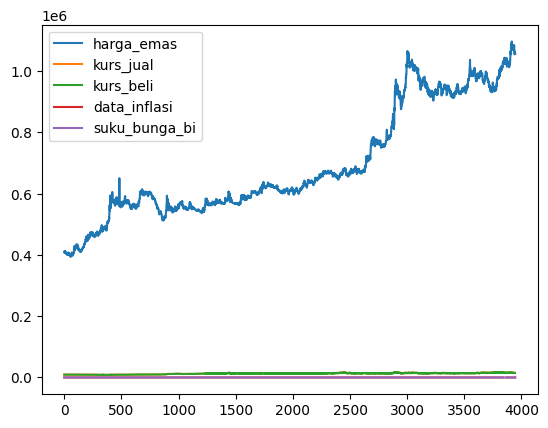

In [37]:
tabel_emas_kurs_inflasi_interest.plot()

## Plot Data

In [38]:
tabel_emas_multi_pycaret = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_multi_pycaret.tanggal = pd.to_datetime(tabel_emas_multi_pycaret.tanggal)
tabel_emas_multi_pycaret.tanggal = tabel_emas_multi_pycaret.tanggal.dt.to_period('B')
tabel_emas_multi_pycaret = tabel_emas_multi_pycaret.drop_duplicates('tanggal')
tabel_emas_multi_pycaret = tabel_emas_multi_pycaret.set_index('tanggal')
print(tabel_emas_multi_pycaret.isna().sum())

# idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
# tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)
# knnimp = KNNImputer()

# kol_tab_pyc = tabel_emas_pycaret.columns.tolist()
# tabel_emas_pycaret = knnimp.fit_transform(tabel_emas_pycaret)
# tabel_emas_pycaret = pd.DataFrame(tabel_emas_pycaret,columns=kol_tab_pyc)
# tabel_emas_pycaret = tabel_emas_pycaret.set_index(idx)
# tabel_emas_pycaret.plot()

harga_emas         0
kurs_jual        419
kurs_beli        419
data_inflasi      21
suku_bunga_bi      0
dtype: int64


In [39]:
tabel_emas_multi_pycaret.index.tolist()[0]

Period('2010-01-04', 'B')

In [40]:
tanggal_tabel_emas = list(map(lambda x: x.date(),tabel_emas_multi_pycaret.index.to_timestamp().tolist()))
print(tanggal_tabel_emas[:5])

[datetime.date(2010, 1, 4), datetime.date(2010, 1, 5), datetime.date(2010, 1, 6), datetime.date(2010, 1, 7), datetime.date(2010, 1, 8)]


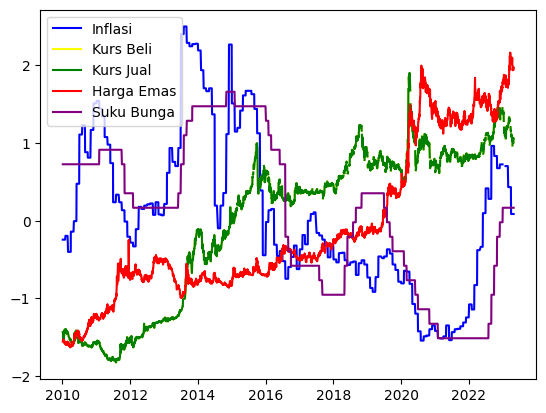

In [41]:
from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
fig, ax = plt.subplots()
ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["data_inflasi"]]),
        label="Inflasi",color="blue")

ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["kurs_beli"]]),
        label="Kurs Beli",color="yellow")

ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["kurs_jual"]]),
        label="Kurs Jual",color="green")

ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["harga_emas"]]),
        label="Harga Emas",color="red")

ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["suku_bunga_bi"]]),
        label="Suku Bunga",color="purple")

plt.legend()
plt.show()

# ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
#         std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["new_cases"]]),
#         label="Kasus baru Covid",color="cyan")

# ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
#         std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["new_deaths"]]),
#         label="Kematian Baru Covid",color="magenta")

Ada Beberapa kesimpulan dari grafik ini
* Ada pengaruh antara Harga Emas dan Kurs Jual
* Ada Pengaruh antara harga emas dan inflasi pada tahun 2010 hingga 2017
* Tetapi, ada hal yang berpengaruh negatif pada inflasi dari 2017 hingga januari 2022
* kemunkinan kurang berpengaruh antara inflasi dengan kurs jual
* kurs jual dan kurs beli memiliki kesamaan grafik , maka mereka cenderung menyatu

## Plot Norm

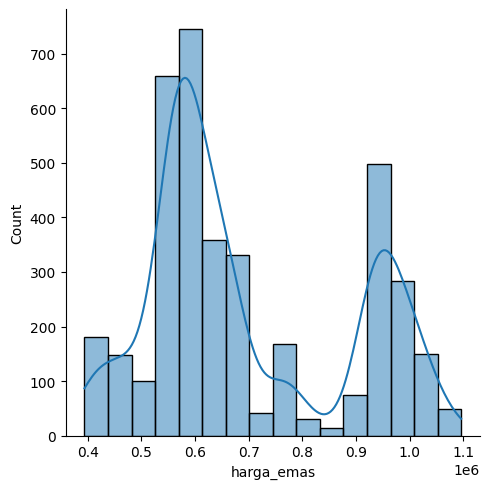

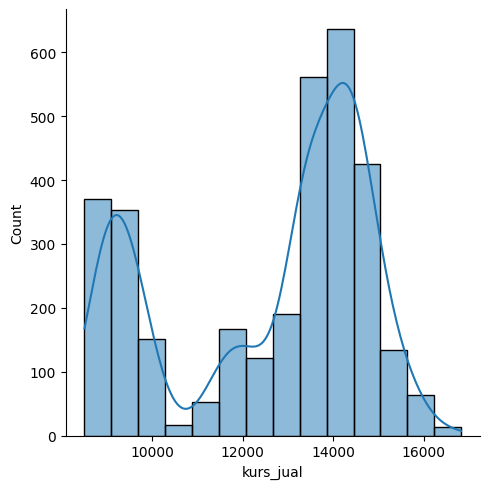

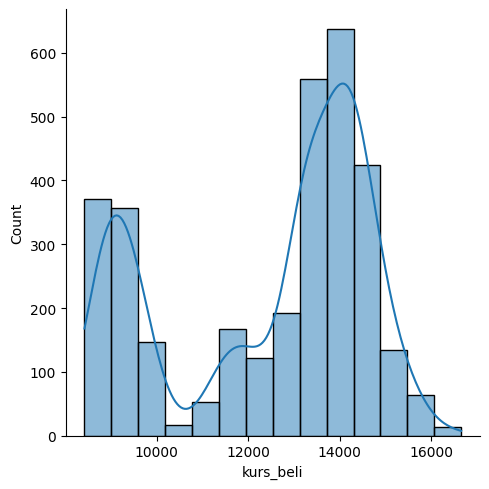

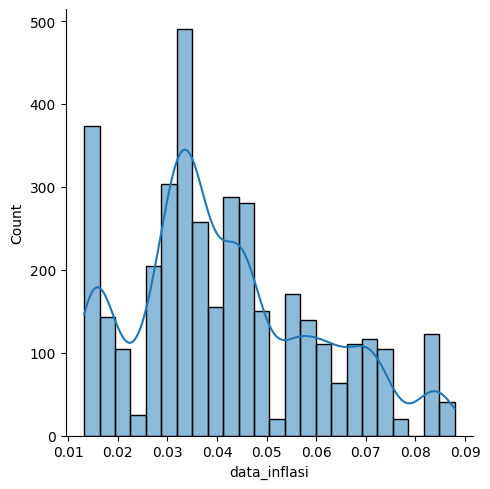

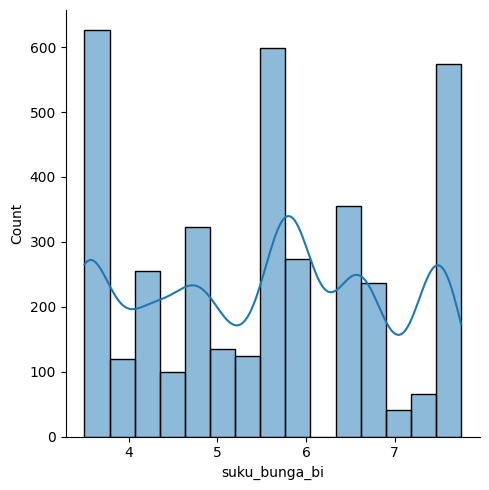

In [42]:
import seaborn as sns
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="harga_emas", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="kurs_jual", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="kurs_beli", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="data_inflasi", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="suku_bunga_bi", kde=True)
# sns.displot(data=tabel_emas_kurs_inflasi_interest, x="new_cases", kde=True)
# sns.displot(data=tabel_emas_kurs_inflasi_interest, x="new_deaths", kde=True)

### Sebaran Data
* Harga Emas memiliki distribusi Bimodal
* Kurs Beli Dollar memiliki distribusi Bimodal
* Kurs Jual Dollar memiliki distribusi Bimodal
* Data Inflasi cenderung memiliki distribusi normal
* Suku Bunga BI cenderung mendekati distribusi banyak modal

## Stationary Analysis

In [43]:
tabel_emas_kurs_inflasi_interest.isna().sum()

tanggal            0
harga_emas         0
kurs_jual        571
kurs_beli        571
data_inflasi      31
suku_bunga_bi      0
dtype: int64

harga_emas         0
kurs_jual        571
kurs_beli        571
data_inflasi      31
suku_bunga_bi      0
dtype: int64
harga_emas       0
kurs_jual        0
kurs_beli        0
data_inflasi     0
suku_bunga_bi    0
dtype: int64


<AxesSubplot: xlabel='tanggal'>

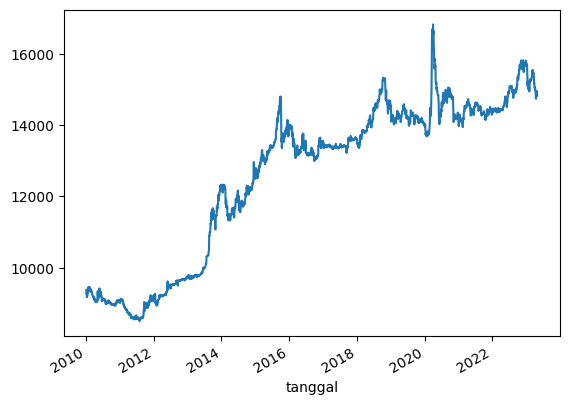

In [44]:
tabel_emas_kurs_inflasi_interest_coba = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_kurs_inflasi_interest_coba = tabel_emas_kurs_inflasi_interest_coba.set_index('tanggal')
print(tabel_emas_kurs_inflasi_interest_coba.isna().sum())

tabel_emas_kurs_inflasi_interest_coba.index = pd.to_datetime(tabel_emas_kurs_inflasi_interest_coba.index)
tabel_emas_kurs_inflasi_interest_coba = tabel_emas_kurs_inflasi_interest_coba.interpolate(method='time')
print(tabel_emas_kurs_inflasi_interest_coba.isna().sum())
tabel_emas_kurs_inflasi_interest_coba.kurs_jual.plot()


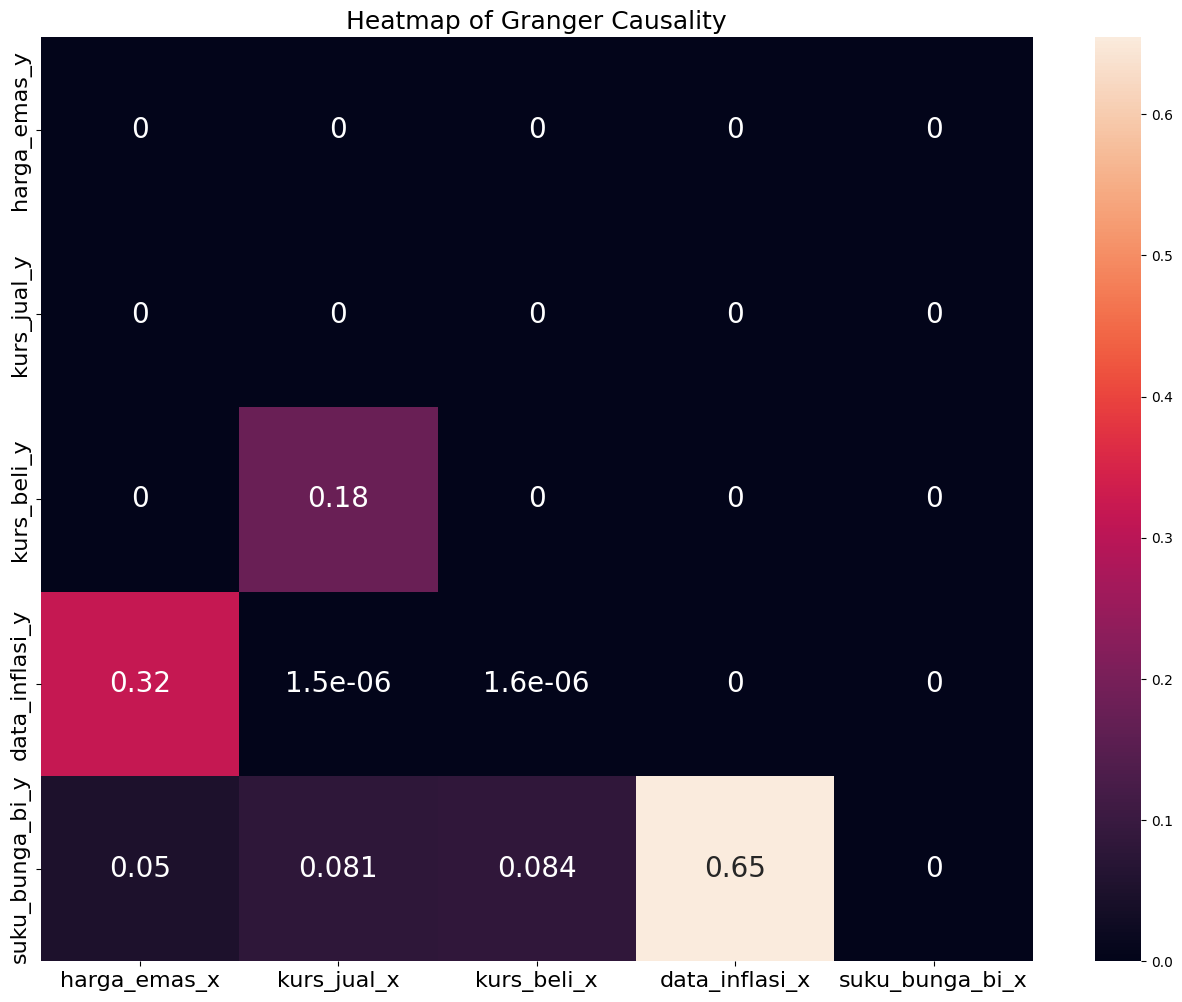

In [45]:
tabel_emas_kurs_inflasi_interest_gr = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_kurs_inflasi_interest_gr = tabel_emas_kurs_inflasi_interest_gr.interpolate()
min_lag_df,test_result_lag  = granger_causality_matrix(tabel_emas_kurs_inflasi_interest_gr,
                                        tabel_emas_kurs_inflasi_interest_gr.drop('tanggal',axis=1).columns.tolist(),
                                        maxlag=100)
# print(f'min_lag_df\n{min_lag_df}\n')
# print(f'test_result_lag\n{test_result_lag}')


plt.figure(figsize=(16, 12))
sns.heatmap(test_result_lag,
            annot=True,
            annot_kws={"size": 20},
           ).set(title='Heatmap of Granger Causality')
plt.xticks(size=16) # Set the size of the x-axis labels
plt.yticks(size=16) # Set the size of the x-axis labels
plt.title('Heatmap of Granger Causality', size=18)
plt.savefig('Heatmap of Granger Causality.png')
plt.show()
# 2menit

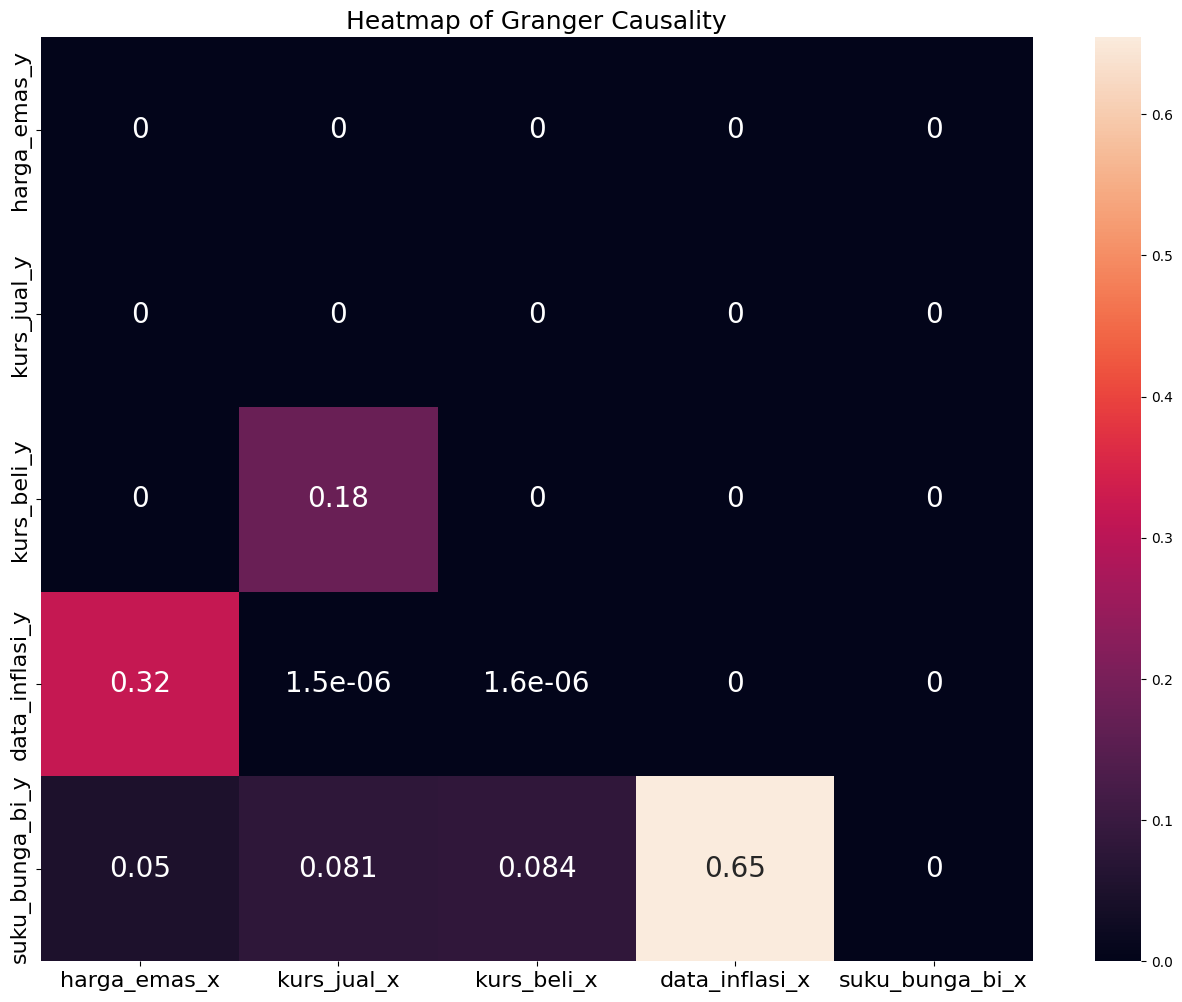

In [46]:
plt.figure(figsize=(16, 12))
sns.heatmap(test_result_lag,
            annot=True,
            annot_kws={"size": 20},
           ).set(title='Heatmap of Granger Causality')
plt.xticks(size=16) # Set the size of the x-axis labels
plt.yticks(size=16) # Set the size of the x-axis labels
plt.title('Heatmap of Granger Causality', size=18)
plt.savefig('Heatmap of Granger Causality.png')
plt.show()

In [47]:
from statsmodels.tsa.stattools import pacf,acf
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

# pacfku = pacf(tabel_emas_kurs_inflasi_interest['harga_emas'],nlags=1648)
acfku = acf(tabel_emas_kurs_inflasi_interest['harga_emas'],nlags=3298)

data_acf = pd.DataFrame({'acf':acfku})
print(data_acf.sort_values('acf')[2174:2176])

# percobaan = tabel_emas_kurs_inflasi_interest[['tanggal','harga_emas']]
# result = seasonal_decompose(percobaan)
# result

           acf
1124  0.075374
1123  0.075961


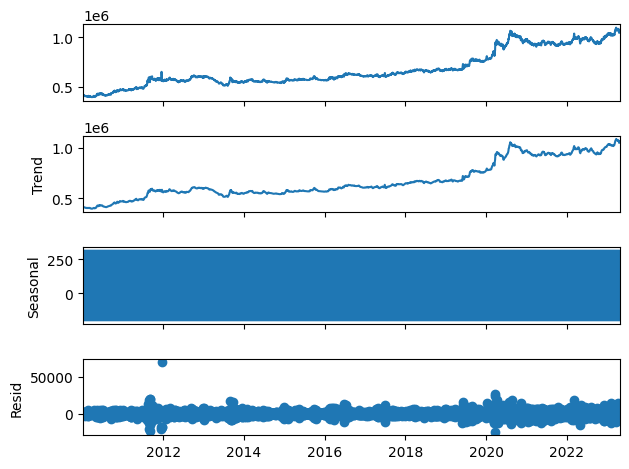

In [48]:
percobaan = tabel_emas_kurs_inflasi_interest[['tanggal','harga_emas']]
percobaan.tanggal = pd.to_datetime(percobaan.tanggal)
percobaan = percobaan.set_index('tanggal')
percobaan = percobaan.asfreq('B')
percobaan = percobaan.interpolate(method='spline',order=5,axis=0)
result = seasonal_decompose(percobaan,)
result.plot()
plt.show()

In [49]:
# from statsforecast.models import (       
#         MSTL,
#         AutoARIMA,
#         AutoETS,
#         HoltWinters,
#         HistoricAverage,
#         AutoCES,
#         AutoTheta,
# )
# from statsforecast import StatsForecast

# from neuralforecast.auto import AutoNHITS


# tabel_emas_kurs_inflasi_interest_uniq = tabel_emas_kurs_inflasi_interest.copy()
# tabel_emas_kurs_inflasi_interest_uniq['unique_id'] = 0
# tabel_emas_kurs_inflasi_interest_uniq['ds'] = tabel_emas_kurs_inflasi_interest_uniq['tanggal']
# tabel_emas_kurs_inflasi_interest_uniq['y'] = tabel_emas_kurs_inflasi_interest_uniq['harga_emas']
# tabel_emas_kurs_inflasi_interest_uniq = tabel_emas_kurs_inflasi_interest_uniq.drop(['harga_emas','tanggal'],axis=1)

# cobain = tabel_emas_kurs_inflasi_interest_uniq[['unique_id','ds','y']]


# y_train = cobain[:int(len(cobain)*0.8)]
# y_test = cobain[int(len(cobain)*0.8):]

# modelan = StatsForecast(models=[AutoARIMA(),
#                                 AutoETS(),
#                                 HoltWinters(season_length=7),
#                                 HistoricAverage(),
#                                 AutoCES(),
#                                 AutoTheta(),
#                                 ],
#                         freq='B')

# modelan.fit(df=y_train)
# y_predict = modelan.predict(h=len(y_test))

# print(y_predict.columns)

# plt.plot(y_test.ds,y_test.y,label='Actual')
# plt.plot(y_predict.ds,y_predict.AutoARIMA,label='AutoARIMA')
# plt.plot(y_predict.ds,y_predict.HoltWinters  ,label='HoltWinters')
# plt.plot(y_predict.ds,y_predict.AutoETS  ,label='AutoETS')
# plt.plot(y_predict.ds,y_predict.CES  ,label='CES')
# plt.plot(y_predict.ds,y_predict.AutoTheta  ,label='AutoTheta')

# plt.legend()
# plt.show()

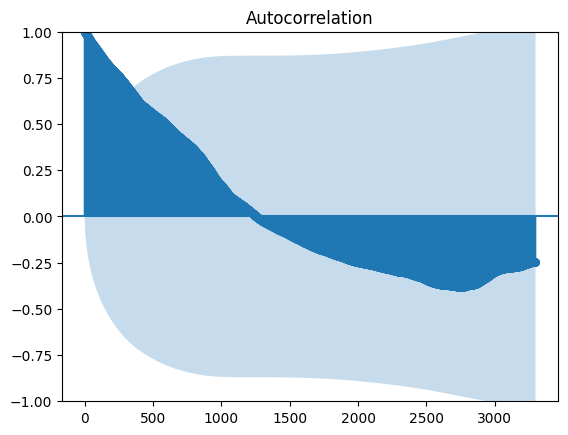

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(tabel_emas_kurs_inflasi_interest['harga_emas'],lags=3298)
# plot_acf(tabel_emas_kurs_inflasi_interest_covid['harga_emas'],lags=)
plt.show()

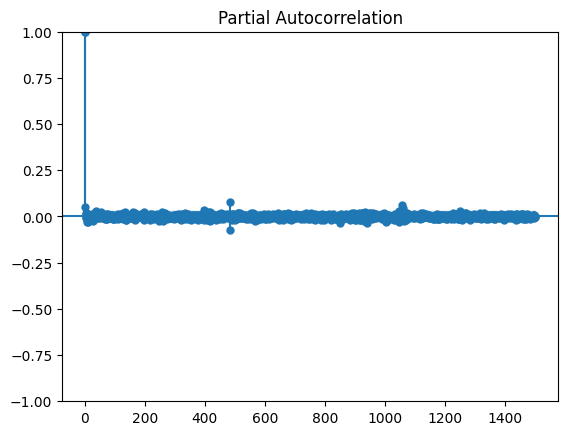

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(tabel_emas_kurs_inflasi_interest['harga_emas'],lags=1500)
plt.show()

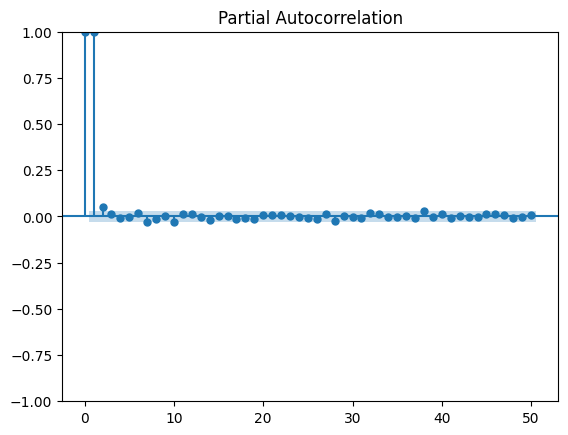

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(tabel_emas_kurs_inflasi_interest['harga_emas'],lags=50)
plt.show()

In [53]:
tabel_emas_mul_pycaret_all = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_mul_pycaret_all.tanggal = pd.to_datetime(tabel_emas_mul_pycaret_all.tanggal)
tanggal_tabel_emas_mul_pycaret_all = pd.date_range(tabel_emas_mul_pycaret_all.tanggal[0],
                                              tabel_emas_mul_pycaret_all.tanggal[tabel_emas_mul_pycaret_all.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_mul_pycaret_all = pd.DataFrame(index=tanggal_tabel_emas_mul_pycaret_all)
tanggal_tabel_emas_mul_pycaret_all.index.name = 'tanggal'

tabel_emas_mul_pycaret_all = tabel_emas_mul_pycaret_all.set_index('tanggal')
tabel_emas_mul_pycaret_all = tanggal_tabel_emas_mul_pycaret_all.merge(tabel_emas_mul_pycaret_all,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )


<AxesSubplot: xlabel='tanggal'>

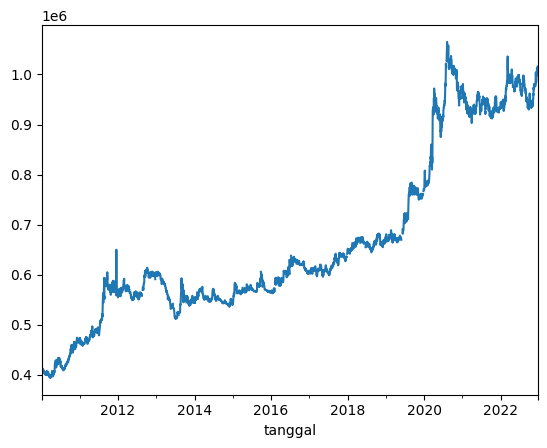

In [54]:
tabel_emas_mul_pycaret_all.harga_emas.plot()

<AxesSubplot: xlabel='tanggal'>

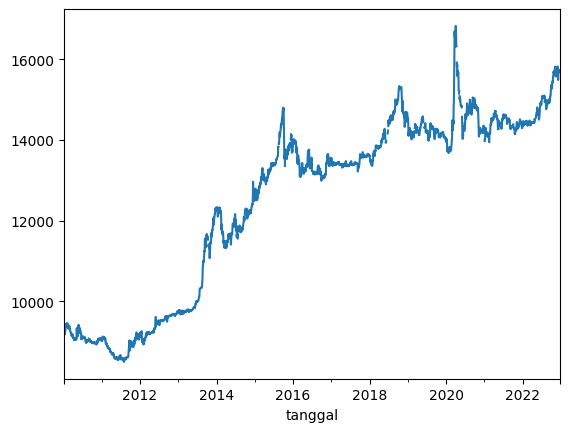

In [55]:
tabel_emas_mul_pycaret_all.kurs_jual.plot()


<AxesSubplot: xlabel='tanggal'>

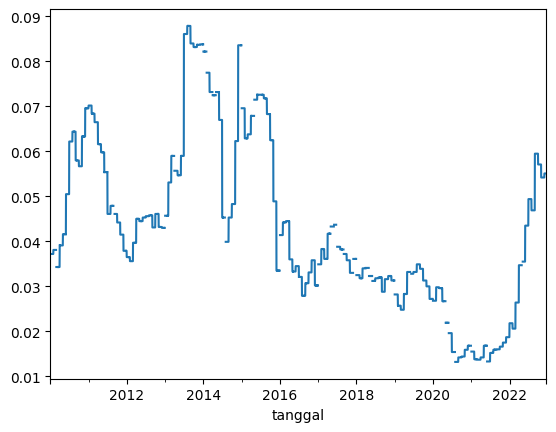

In [56]:
tabel_emas_mul_pycaret_all.data_inflasi.plot()

<AxesSubplot: xlabel='tanggal'>

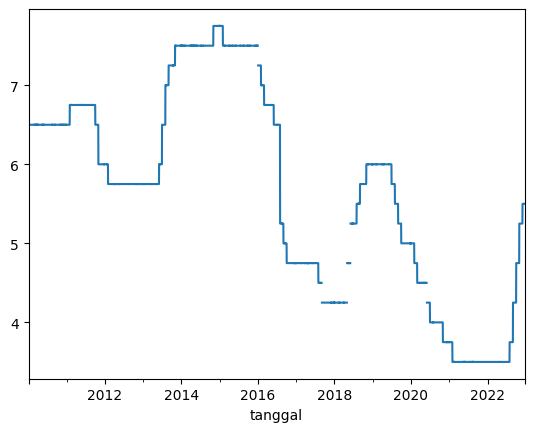

In [57]:
tabel_emas_mul_pycaret_all.suku_bunga_bi.plot()

In [58]:
# from statsforecast.adapters.prophet import AutoARIMAProphet
# model_arprophet = AutoARIMAProphet()
# tabel_emas_arpr = tabel_emas_kurs_inflasi_interest.copy()
# tabel_emas_arpr.tanggal = pd.to_datetime(tabel_emas_arpr.tanggal)
# tabel_emas_arpr.tanggal = tabel_emas_arpr.tanggal.dt.to_period('B')
# tabel_emas_arpr = tabel_emas_arpr.drop_duplicates('tanggal')
# tabel_emas_arpr = tabel_emas_arpr.set_index('tanggal')

# idx = pd.period_range(min(tabel_emas_arpr.index), max(tabel_emas_arpr.index))
# tabel_emas_arpr = tabel_emas_arpr.reindex(idx, fill_value=np.nan)
# tabel_emas_arpr = tabel_emas_arpr.reset_index()
# tabel_emas_arpr = tabel_emas_arpr[['index','harga_emas']]
# tabel_emas_arpr.columns = ['ds','y']
# tabel_emas_arpr.ds = pd.to_datetime(tabel_emas_arpr.ds.astype(str))
# model_arprophet.add_country_holidays('ID')
# model_arprophet.fit(tabel_emas_arpr)
# future = model_arprophet.make_future_dataframe(365)
# forecast = model_arprophet.predict(future)
# fig = model_arprophet.plot(forecast)

# Pycaret

In [59]:
model_pakai_ts = ['naive', 'grand_means', 'snaive', 'prophet', 'lr_cds_dt','arima','auto_arima',
               'en_cds_dt', 'ridge_cds_dt', 'lasso_cds_dt', 'lar_cds_dt',
               'llar_cds_dt', 'br_cds_dt', 'huber_cds_dt', 'par_cds_dt', 
               'omp_cds_dt', 'knn_cds_dt', 'dt_cds_dt', 'rf_cds_dt','et_cds_dt',
               'gbr_cds_dt', 'ada_cds_dt', 'xgboost_cds_dt', 'lightgbm_cds_dt', 
               'catboost_cds_dt']

In [60]:
tabel_emas_kurs_inflasi_interest.describe()

,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
count,3.827000e+03,3256.000000,3256.000000,3796.000000,3827.000000
mean,6.955277e+05,12573.524748,12448.376692,0.041688,5.525281
std,1.849930e+05,2232.778886,2210.570333,0.018477,1.339734
min,3.940000e+05,8502.000000,8418.000000,0.013200,3.500000
25%,5.660000e+05,9789.000000,9691.000000,0.030000,4.250000
50%,6.210000e+05,13405.000000,13271.000000,0.037900,5.750000
75%,9.220000e+05,14330.550000,14188.175000,0.054700,6.500000
max,1.096000e+06,16824.710000,16657.300000,0.087900,7.750000


## Pycaret Uni All Models

,Description,Value
0,session_id,42
1,Target,harga_emas
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3475, 1)"
5,Transformed data shape,"(3475, 1)"
6,Transformed train set shape,"(2745, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,5.5%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3475.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,674525.248148
3,Summary,Statistics,Transformed,Median,,608870.99531
4,Summary,Statistics,Transformed,Standard Deviation,,178454.921414
5,Summary,Statistics,Transformed,Variance,,31846158976.722122
6,Summary,Statistics,Transformed,Kurtosis,,-0.703589
7,Summary,Statistics,Transformed,Skewness,,0.710449
8,Summary,Statistics,Transformed,# Distinct Values,,770.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",79811.537083


<AxesSubplot: xlabel='tanggal'>

,harga_emas
tanggal,
2010-01-04,408000.0
2010-01-05,410000.0
2010-01-06,410000.0
2010-01-07,412000.0
2010-01-08,410000.0


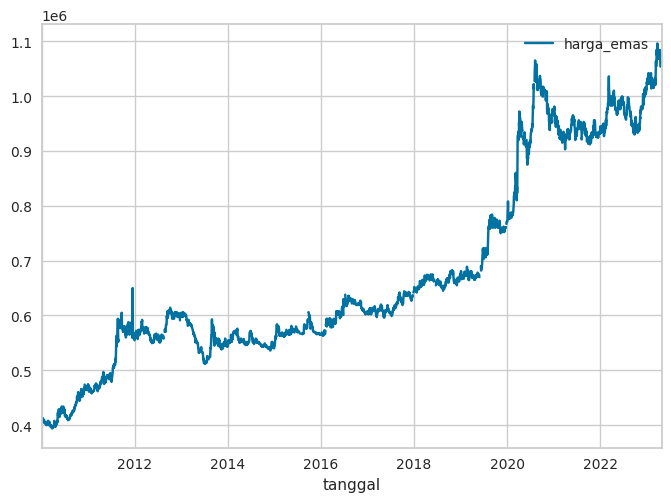

In [61]:
from pycaret.time_series import *

tabel_emas_uni_pycaret = tabel_emas.copy()
tabel_emas_uni_pycaret.tanggal = pd.to_datetime(tabel_emas_uni_pycaret.tanggal)
tanggal_tabel_emas_uni_pycaret = pd.date_range(tabel_emas_uni_pycaret.tanggal[0],
                                              tabel_emas_uni_pycaret.tanggal[tabel_emas_uni_pycaret.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_uni_pycaret = pd.DataFrame(index=tanggal_tabel_emas_uni_pycaret)
tanggal_tabel_emas_uni_pycaret.index.name = 'tanggal'

tabel_emas_uni_pycaret = tabel_emas_uni_pycaret.set_index('tanggal')
tabel_emas_uni_pycaret = tanggal_tabel_emas_uni_pycaret.merge(tabel_emas_uni_pycaret,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )

pycaret_time_series_uni_all = TSForecastingExperiment()
pycaret_time_series_uni_all.setup(data=tabel_emas_uni_pycaret,
            target='harga_emas',
            numeric_imputation_target='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            #transform_target="box-cox",
            fold=3,
            fh=730,
            session_id=42,
            #fe_target_rr = [Catch22()],
            )
display(pycaret_time_series_uni_all.check_stats())
display(tabel_emas_uni_pycaret.plot())
display(tabel_emas_uni_pycaret.head())

In [62]:
pycaret_time_series_uni_all.models().index.tolist()

['naive',
 'grand_means',
 'snaive',
 'polytrend',
 'arima',
 'auto_arima',
 'exp_smooth',
 'ets',
 'theta',
 'stlf',
 'croston',
 'bats',
 'tbats',
 'prophet',
 'lr_cds_dt',
 'en_cds_dt',
 'ridge_cds_dt',
 'lasso_cds_dt',
 'llar_cds_dt',
 'br_cds_dt',
 'huber_cds_dt',
 'omp_cds_dt',
 'knn_cds_dt',
 'dt_cds_dt',
 'rf_cds_dt',
 'et_cds_dt',
 'gbr_cds_dt',
 'ada_cds_dt',
 'xgboost_cds_dt',
 'lightgbm_cds_dt',
 'catboost_cds_dt']

In [63]:
model_ts = pycaret_time_series_uni_all.models().index.tolist()
try:
    model_ts.remove('arima')
except:
    pass

try:
    model_ts.remove('auto_arima')
except:
    pass

try:
    model_ts.remove('ets')
except:
    pass

try:
    model_ts.remove('tbats')
except:
    pass
try:
    model_ts.remove('bats')
except:
    pass

In [64]:
# model_pycaret_uni_all = pycaret_time_series_uni_all.compare_models(include=model_ts)
model_pycaret_uni_all = pycaret_time_series_uni_all.compare_models(include=['xgboost_cds_dt',
                                                                           'prophet',
                                                                            'stlf',
                                                                           ],
                                                                   sort="SMAPE",
                                                                   #budget_time=30
                                                                  )
model_pycaret_uni_all

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
prophet,Prophet,1.1585,1.2211,60899.3367,77978.2678,0.0942,0.0965,-4.5570,1.6000
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.2567,1.3909,78960.7108,100242.1460,0.1296,0.1188,-17.6797,141.0767
stlf,STLF,1.2839,1.3773,82294.6729,101433.2264,0.1356,0.1227,-21.3049,1.2833


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

ProphetPeriodPatched()

In [65]:
if(model_pycaret_uni_all.__class__.__name__!="ARIMA"):
    best_model_uni_all = pycaret_time_series_uni_all.tune_model(model_pycaret_uni_all)
    display(best_model_uni_all)
else:
    best_model_uni_all = model_pycaret_uni_all

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012-02-17,0.7647,0.8777,69383.5706,84381.4932,0.1262,0.1155,-12.7810
1,2014-12-05,0.8250,0.7737,42269.6772,49341.5306,0.0694,0.0728,-2.9798
2,2017-09-22,1.4220,1.7210,57479.1754,90373.6238,0.0713,0.0773,-0.1437
Mean,NaT,1.0039,1.1242,56377.4744,74698.8825,0.0890,0.0885,-5.3015
SD,NaT,0.2967,0.4242,11096.5794,18096.4616,0.0263,0.0191,5.4141


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.1s finished


ProphetPeriodPatched(changepoint_prior_scale=0.016439324494196616,
                     holidays_prior_scale=0.01095960453692584,
                     seasonality_prior_scale=7.886714129990491)

In [66]:
if(model_pycaret_uni_all.__class__.__name__!="ARIMA"):
    pycaret_time_series_uni_all.plot_model(model_pycaret_uni_all)

In [67]:
if(model_pycaret_uni_all.__class__.__name__!="ARIMA"):
    pycaret_time_series_uni_all.plot_model(model_pycaret_uni_all,plot="decomp")

In [68]:
if(model_pycaret_uni_all.__class__.__name__!="ARIMA"):
    pycaret_time_series_uni_all.plot_model(model_pycaret_uni_all,plot="decomp_stl")

In [69]:
if(model_pycaret_uni_all.__class__.__name__!="ARIMA"):
    pycaret_time_series_uni_all.plot_model(model_pycaret_uni_all,plot="diagnostics")

In [70]:
final_model_uni_all = pycaret_time_series_uni_all.finalize_model(best_model_uni_all)
final_model_uni_all

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42))])),
                                                               ('model',
                                                                ProphetPeriodPatched(changepoint_prior_scale=0.016439324494196616,
                                                                                     holidays_prior_scale=0.01095960453692584,
                                                                                     seasonality_prior_scale=7.886714129990491))]))])

<AxesSubplot: >

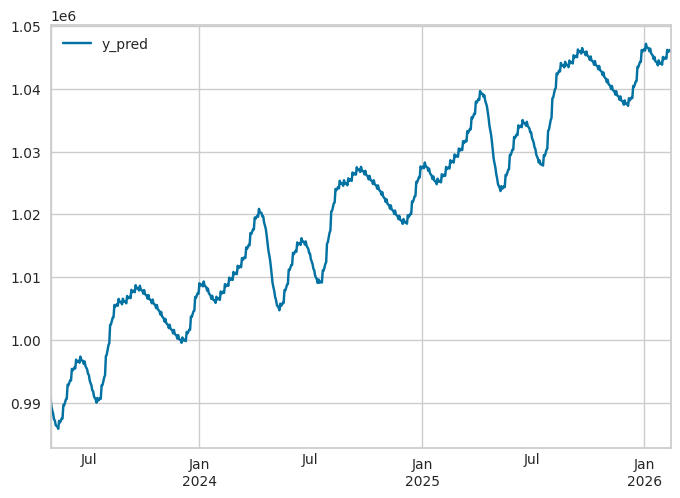

In [71]:
hasil_ts_uni_all = pycaret_time_series_uni_all.predict_model(final_model_uni_all,fh=730)
hasil_ts_uni_all.plot()

In [72]:
hasil_ts_uni_all.columns = ['harga_emas']
hasil_ts_uni_all.head(10)

,harga_emas
2023-05-01,990518.9600
2023-05-02,989354.9212
2023-05-03,988725.8469
2023-05-04,988201.6748
2023-05-05,987328.7974
2023-05-08,987155.4212
2023-05-09,986426.1343
2023-05-10,986255.7961
2023-05-11,986207.5066
2023-05-12,985820.6634


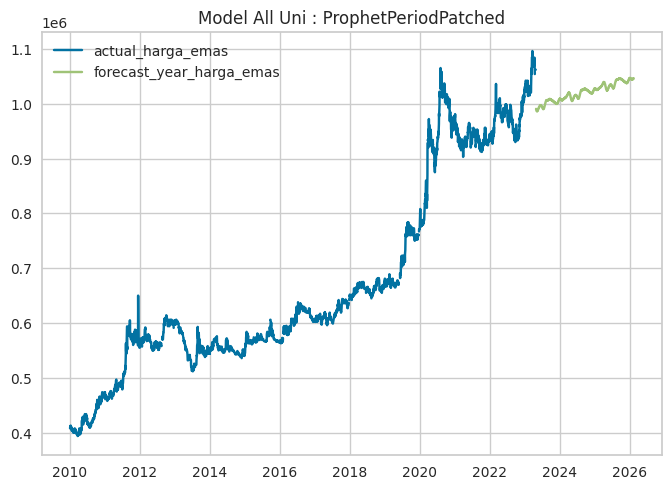

In [73]:
try:
    nama_model_uni_all = final_model_uni_all.get_params()['forecaster__model'].__class__.__name__
except:
    nama_model_uni_all = ''
    pass
    
plt.plot(tabel_emas_uni_pycaret.index,tabel_emas_uni_pycaret.harga_emas,label='actual_harga_emas')
plt.plot(hasil_ts_uni_all.index,hasil_ts_uni_all.harga_emas,label='forecast_year_harga_emas')
plt.title(f'Model All Uni : {nama_model_uni_all}')
plt.legend()
plt.show()

## Pycaret Prophet Uni

In [74]:
from pycaret.time_series import *

tabel_emas_uni_pycaret_prophet = tabel_emas.copy()
tabel_emas_uni_pycaret_prophet.tanggal = pd.to_datetime(tabel_emas_uni_pycaret_prophet.tanggal)
tanggal_tabel_emas_uni_pycaret_prophet = pd.date_range(tabel_emas_uni_pycaret_prophet.tanggal[0],
                                              tabel_emas_uni_pycaret_prophet.tanggal[tabel_emas_uni_pycaret_prophet.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_uni_pycaret_prophet = pd.DataFrame(index=tanggal_tabel_emas_uni_pycaret_prophet)
tanggal_tabel_emas_uni_pycaret_prophet.index.name = 'tanggal'

tabel_emas_uni_pycaret_prophet = tabel_emas_uni_pycaret_prophet.set_index('tanggal')
tabel_emas_uni_pycaret_prophet = tanggal_tabel_emas_uni_pycaret_prophet.merge(tabel_emas_uni_pycaret_prophet,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )

pycaret_prophet_uni = TSForecastingExperiment()
pycaret_prophet_uni.setup(data=tabel_emas_uni_pycaret_prophet,
            target='harga_emas',
            numeric_imputation_target='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            session_id=42,
            # fe_target_rr=[Catch22(catch24=True, outlier_norm=True)],
            # transform_target="box-cox",
            fold=3,
            fh=730)
pycaret_prophet_uni.check_stats()

,Description,Value
0,session_id,42
1,Target,harga_emas
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3475, 1)"
5,Transformed data shape,"(3475, 1)"
6,Transformed train set shape,"(2745, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,5.5%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3475.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,674525.248148
3,Summary,Statistics,Transformed,Median,,608870.99531
4,Summary,Statistics,Transformed,Standard Deviation,,178454.921414
5,Summary,Statistics,Transformed,Variance,,31846158976.722122
6,Summary,Statistics,Transformed,Kurtosis,,-0.703589
7,Summary,Statistics,Transformed,Skewness,,0.710449
8,Summary,Statistics,Transformed,# Distinct Values,,770.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",79811.537083


In [75]:
model_pycaret_prophet_uni = pycaret_prophet_uni.create_model('xgboost_cds_dt')
model_pycaret_prophet_uni.get_params()['regressor'].get_params()

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012-02-17,1.5283,1.7052,138664.6274,163937.6546,0.2513,0.2141,-51.0169
1,2014-12-05,0.7029,0.6414,36017.6712,40902.4257,0.0602,0.0582,-1.7348
2,2017-09-22,1.5388,1.8260,62199.8337,95886.3578,0.0774,0.0843,-0.2875
Mean,NaT,1.2567,1.3909,78960.7108,100242.1460,0.1296,0.1188,-17.6797
SD,NaT,0.3916,0.5322,43549.1650,50323.2653,0.0863,0.0682,23.5803


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [76]:
model_pycaret_prophet_uni_tuned = pycaret_prophet_uni.tune_model(model_pycaret_prophet_uni)
display(model_pycaret_prophet_uni)
model_pycaret_prophet_uni.get_params()['regressor'].get_params()

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012-02-17,1.6778,1.8324,152232.8973,176164.9165,0.2755,0.2330,-59.0656
1,2014-12-05,0.9251,0.7813,47402.9589,49824.4101,0.0800,0.0767,-3.0581
2,2017-09-22,1.3885,1.7082,56124.7974,89702.9315,0.0693,0.0752,-0.1268
Mean,NaT,1.3305,1.4407,85253.5512,105230.7527,0.1416,0.1283,-20.7501
SD,NaT,0.3100,0.4690,47495.2083,52734.0233,0.0948,0.0740,27.1195


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 62.2min finished


BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [261,
                                                                        260,
                                                                        259,
                                                                        258,
                                                                        257,
                                                                        256,
                                                                        255,
                                                                        254,
                                                                        253,
                                                                        252,
                                                                        251,
                                                                        250,
                                                                        249,
                                                                        248,
                                                                        247,
                                                                        246,
                                                                        245,
                                                                        244,
                                                                        243,
                                                                        242,
                                                                        241,
                                                                        240,
                                                                        239,
                                                                        238,
                                                                        237,
                                                                        236,
                                                                        235,
                                                                        234,
                                                                        233,
                                                                        232, ...]},
                                                   n_jobs=1)],
                    regressor=XGBRegressor(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           earl...
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                    sp=261, window_length=261)

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [77]:
pycaret_prophet_uni.plot_model(model_pycaret_prophet_uni_tuned)

In [78]:
pycaret_prophet_uni.plot_model(model_pycaret_prophet_uni_tuned,plot='diagnostics')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [79]:
pycaret_prophet_uni.plot_model(model_pycaret_prophet_uni_tuned,plot='decomp_stl')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [80]:
model_pycaret_prophet_uni_tuned_finalized = pycaret_prophet_uni.finalize_model(model_pycaret_prophet_uni_tuned)
model_pycaret_prophet_uni_tuned_finalized

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42))])),
                                                               ('model',
                                                                BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [261,
                                                                                                                                        260,
                                                                                                                                        259,
                                                                                                                                        258,
                                                                                                                                        257,
                                                                                                                                        256,
                                                                                                                                        255,
                                                                                                                                        254,
                                                                                                                                        253,
                                                                                                                                        252,
                                                                                                                                        251,
                                                                                                                                        250,
                                                                                                                                        249,
                                                                                                                                        248,
                                                                                                                                        247,
                                                                                                                                        246,
                                                                                                                                        245,
                                                                                                                                        244,
                                                                                                                                        243,
                                                                                                                                        242,
                                                                                                                                        241,
                                                                                                                                        240,
                                                                                                                                        239,
                                                                                                                                        238...
                                                                                                           importance_type=None,
                                                 

              harga_emas
2023-05-01  1.066103e+06
2023-05-02  1.074363e+06
2023-05-03  1.064089e+06
2023-05-04  1.063304e+06
2023-05-05  1.063518e+06
...                  ...
2026-02-09  1.086968e+06
2026-02-10  1.081529e+06
2026-02-11  1.082673e+06
2026-02-12  1.080736e+06
2026-02-13  1.076603e+06

[730 rows x 1 columns]


<AxesSubplot: >

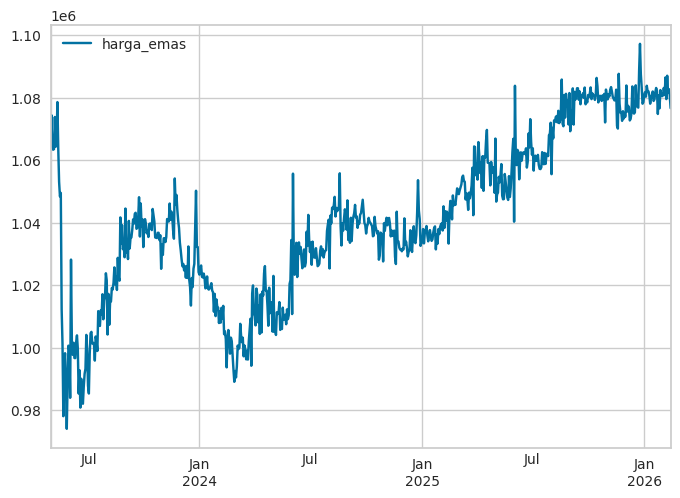

In [81]:
hasil_ts_uni_prophet =  pycaret_prophet_uni.predict_model(model_pycaret_prophet_uni_tuned_finalized,fh=730)
hasil_ts_uni_prophet.columns = ['harga_emas']
print(hasil_ts_uni_prophet)
hasil_ts_uni_prophet.plot()

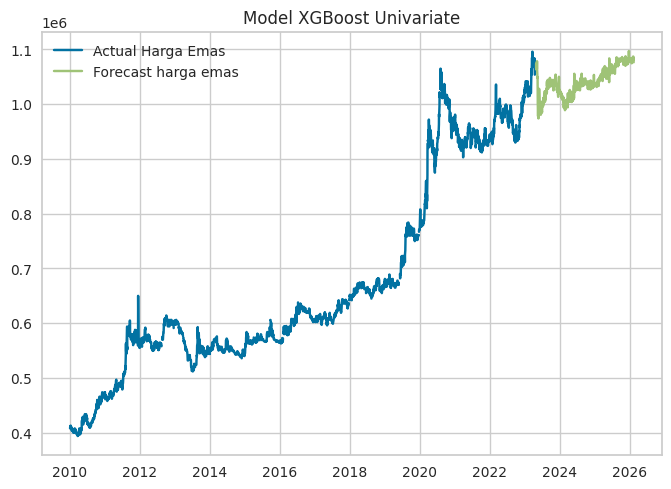

In [82]:
plt.plot(tabel_emas_uni_pycaret_prophet.index.to_period().to_timestamp(),tabel_emas_uni_pycaret_prophet.harga_emas,label='Actual Harga Emas')
plt.plot(hasil_ts_uni_prophet.index.to_timestamp(),hasil_ts_uni_prophet.harga_emas,label='Forecast harga emas')
plt.title('Model XGBoost Univariate')
plt.legend()
plt.show()

## Pycaret Multi

In [83]:
from datetime import date

tabel_emas_kurs_inflasi_interest[tabel_emas_kurs_inflasi_interest.tanggal==date(2010,2,26)]

,tanggal,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi


In [84]:
model_pakai_ts = ['naive', 'grand_means', 'snaive', 'prophet', 'lr_cds_dt',
               'en_cds_dt', 'ridge_cds_dt', 'lasso_cds_dt', 'lar_cds_dt',
               'llar_cds_dt', 'br_cds_dt', 'huber_cds_dt', 'par_cds_dt', 
               'omp_cds_dt', 'knn_cds_dt', 'dt_cds_dt', 'rf_cds_dt','et_cds_dt',
               'gbr_cds_dt', 'ada_cds_dt', 'xgboost_cds_dt', 'lightgbm_cds_dt', 
               'catboost_cds_dt']

In [85]:
from sklearn.impute import KNNImputer
from pycaret.time_series import *

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi_interest.reset_index(drop=True)

tabel_emas_mul_pycaret_all = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_mul_pycaret_all.tanggal = pd.to_datetime(tabel_emas_mul_pycaret_all.tanggal)
tanggal_tabel_emas_mul_pycaret_all = pd.date_range(tabel_emas_mul_pycaret_all.tanggal[0],
                                              tabel_emas_mul_pycaret_all.tanggal[tabel_emas_mul_pycaret_all.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_mul_pycaret_all = pd.DataFrame(index=tanggal_tabel_emas_mul_pycaret_all)
tanggal_tabel_emas_mul_pycaret_all.index.name = 'tanggal'

tabel_emas_mul_pycaret_all = tabel_emas_mul_pycaret_all.set_index('tanggal')
tabel_emas_mul_pycaret_all = tanggal_tabel_emas_mul_pycaret_all.merge(tabel_emas_mul_pycaret_all,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )
# print(tabel_emas_pycaret.isna().sum())

pycaret_mul_time_series_all = TSForecastingExperiment()
pycaret_mul_time_series_all.setup(data=tabel_emas_mul_pycaret_all,session_id=42,
            target='harga_emas',
            numeric_imputation_target='drift',
            numeric_imputation_exogenous='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            #transform_target="box-cox",
            #transform_exogenous="box-cox",
            fold=3,
            fh=730)

pycaret_mul_time_series_all.check_stats()

,Description,Value
0,session_id,42
1,Target,harga_emas
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(3475, 5)"
5,Transformed data shape,"(3475, 5)"
6,Transformed train set shape,"(2745, 5)"
7,Transformed test set shape,"(730, 5)"
8,Rows with missing values,6.9%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3475.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,674525.248148
3,Summary,Statistics,Transformed,Median,,608870.99531
4,Summary,Statistics,Transformed,Standard Deviation,,178454.921414
5,Summary,Statistics,Transformed,Variance,,31846158976.722122
6,Summary,Statistics,Transformed,Kurtosis,,-0.703589
7,Summary,Statistics,Transformed,Skewness,,0.710449
8,Summary,Statistics,Transformed,# Distinct Values,,770.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",79811.537083


In [86]:
model_pakai_ts = pycaret_mul_time_series_all.models().index.tolist()
try:
    model_pakai_ts.remove('arima')
except:
    pass

try:
    model_pakai_ts.remove('auto_arima')
except:
    pass

try:
    model_pakai_ts.remove('ets')
except:
    pass

try:
    model_pakai_ts.remove('tbats')
except:
    pass

try:
    model_pakai_ts.remove('bats')
except:
    pass

In [87]:
model_mul_pycaret_all = pycaret_mul_time_series_all.compare_models(include=['xgboost_cds_dt',
                                                                           'prophet',
                                                                            'stlf',
                                                                           ],
                                                                   sort="SMAPE"
                                                                   #budget_time=30
                                                                  )
# model_mul_pycaret_all_tuned = pycaret_mul_time_series_all.tune_model(model_mul_pycaret_all,
#                                       search_algorithm='random')
# display(model_mul_pycaret_all_tuned)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0598,1.2191,70422.8936,90459.7034,0.1166,0.1055,-17.7091,141.7733
prophet,Prophet,1.4155,1.4379,76791.5132,94725.5232,0.1209,0.1214,-8.5939,1.8867
stlf,STLF,1.2839,1.3773,82294.6729,101433.2264,0.1356,0.1227,-21.3049,1.4300


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

In [88]:
if(model_mul_pycaret_all.__class__.__name__=="ARIMA"):
    model_mul_pycaret_all_tuned = pycaret_mul_time_series_all.tune_model(model_mul_pycaret_all,
                                          search_algorithm='random')
else:
    model_mul_pycaret_all_tuned = model_mul_pycaret_all

display(model_mul_pycaret_all_tuned)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [261,
                                                                        260,
                                                                        259,
                                                                        258,
                                                                        257,
                                                                        256,
                                                                        255,
                                                                        254,
                                                                        253,
                                                                        252,
                                                                        251,
                                                                        250,
                                                                        249,
                                                                        248,
                                                                        247,
                                                                        246,
                                                                        245,
                                                                        244,
                                                                        243,
                                                                        242,
                                                                        241,
                                                                        240,
                                                                        239,
                                                                        238,
                                                                        237,
                                                                        236,
                                                                        235,
                                                                        234,
                                                                        233,
                                                                        232, ...]},
                                                   n_jobs=1)],
                    regressor=XGBRegressor(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           earl...
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                    sp=261, window_length=261)

In [89]:
pycaret_mul_time_series_all.plot_model(model_mul_pycaret_all_tuned)

In [90]:
# pycaret_mul_time_series_all.plot_model(model_mul_pycaret_all_tuned,plot="diagnostics")

In [91]:
# pycaret_mul_time_series_all.plot_model(model_mul_pycaret_all_tuned,plot="decomp_stl")

In [92]:
model_mul_pycaret_all_tuned_finalized = pycaret_mul_time_series_all.finalize_model(model_mul_pycaret_all_tuned)
model_mul_pycaret_all_tuned_finalized

ForecastingPipeline(steps=[('transformer_exogenous',
                            TransformerPipeline(steps=[('numerical_imputer',
                                                        Imputer(random_state=42))])),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42))])),
                                                               ('model',
                                                                BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={...
                                                                                                           importance_type=None,
                                                                                                           interaction_constraints=None,
                                                                                                           learning_rate=None,
                                                                                                           max_bin=None,
                                                                                                           max_cat_threshold=None,
                                                                                                           max_cat_to_onehot=None,
                                                                                                           max_delta_step=None,
                                                                                                           max_depth=None,
                                                                                                           max_leaves=None,
                                                                                                           min_child_weight=None,
                                                                                                           missing=nan,
                                                                                                           monotone_constraints=None,
                                                                                                           n_estimators=100,
                                                                                                           n_jobs=-1,
                                                                                                           num_parallel_tree=None,
                                                                                                           predictor=None,
                                                                                                           random_state=42, ...),
                                                                                    sp=261,
                                                                                    window_length=261))]))])

# Pycaret For Exogenous

In [93]:
kolom_exo = tabel_emas_mul_pycaret_all.columns.tolist()
kolom_exo.remove('harga_emas')
kolom_exo

['kurs_jual', 'kurs_beli', 'data_inflasi', 'suku_bunga_bi']

In [94]:
kolom_exo = tabel_emas_mul_pycaret_all.columns.tolist()
kolom_exo.remove('harga_emas')

exog_exps = []
exog_models = []
for exog_var in kolom_exo:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=tabel_emas_mul_pycaret_all[exog_var], fh=730,
        numeric_imputation_target="drift", 
        session_id=42,
        #transform_target="box-cox",
        max_sp_to_consider=None,
        num_sps_to_use=-1,
    )

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    display(exog_exp.check_stats())
    best = exog_exp.compare_models(include=model_pakai_ts,
        #include=['xgboost_cds_dt',
                                            #'prophet',
                                            #'stlf',],
                                   sort="SMAPE",
                                   budget_time=30
                                  )
    final_exog_model = exog_exp.finalize_model(best)
    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# Step 2: Get future predictions for exog variables ----
future_exog_all = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog_all = pd.concat(future_exog_all, axis=1)
future_exog_all.columns = kolom_exo
future_exog_all.head()

,Description,Value
0,session_id,42
1,Target,kurs_jual
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3475, 1)"
5,Transformed data shape,"(3475, 1)"
6,Transformed train set shape,"(2745, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,6.3%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3475.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,12575.773834
3,Summary,Statistics,Transformed,Median,,13398.0
4,Summary,Statistics,Transformed,Standard Deviation,,2219.485464
5,Summary,Statistics,Transformed,Variance,,4926115.72589
6,Summary,Statistics,Transformed,Kurtosis,,-1.150636
7,Summary,Statistics,Transformed,Skewness,,-0.552093
8,Summary,Statistics,Transformed,# Distinct Values,,2529.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",80366.236555


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
stlf,STLF,3.7639,3.4199,896.4553,1112.2313,0.0738,0.0805,-1.2935,0.1267
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,4.3413,3.8274,1060.3849,1273.8554,0.0866,0.0932,-2.0294,40.6000
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,4.3673,3.8623,1070.9997,1291.8198,0.0872,0.0936,-2.1362,33.0900
prophet,Prophet,4.4479,3.8131,1108.6734,1303.5672,0.0896,0.0970,-2.6501,1.8933
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,4.5825,3.9882,1138.0238,1347.1060,0.0921,0.0983,-2.4781,41.9533
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,4.5986,4.0014,1141.7292,1352.4072,0.0925,0.0986,-2.5208,81.0800
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,4.6064,3.9797,1148.4052,1345.8136,0.0927,0.0987,-2.4825,32.5300
naive,Naive Forecaster,4.5348,3.8915,1165.8725,1361.5280,0.0921,0.0992,-3.3268,1.7333
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,4.6268,4.0623,1133.6780,1361.6255,0.0926,0.1000,-2.5289,35.2867
croston,Croston,4.5799,3.9252,1176.4500,1373.1228,0.0931,0.1003,-3.5447,0.0767


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,kurs_beli
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3475, 1)"
5,Transformed data shape,"(3475, 1)"
6,Transformed train set shape,"(2745, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,6.3%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3475.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,12450.603579
3,Summary,Statistics,Transformed,Median,,13264.0
4,Summary,Statistics,Transformed,Standard Deviation,,2197.409163
5,Summary,Statistics,Transformed,Variance,,4828607.028411
6,Summary,Statistics,Transformed,Kurtosis,,-1.150608
7,Summary,Statistics,Transformed,Skewness,,-0.552075
8,Summary,Statistics,Transformed,# Distinct Values,,2520.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",80366.094166


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
stlf,STLF,3.7600,3.4184,887.5669,1101.1650,0.0738,0.0805,-1.2936,0.2000
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,4.3308,3.8184,1048.0770,1257.9316,0.0865,0.0931,-2.0113,64.1567
prophet,Prophet,4.4603,3.8253,1100.8528,1294.0903,0.0900,0.0974,-2.6629,2.1033
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,4.6003,3.9771,1136.3712,1331.9440,0.0927,0.0987,-2.4790,53.6200
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,4.6099,4.1208,1139.7067,1395.5697,0.0928,0.0990,-2.9619,53.9000
naive,Naive Forecaster,4.5302,3.8897,1154.0809,1347.7897,0.0921,0.0992,-3.3236,0.1133
croston,Croston,4.5758,3.9238,1164.7014,1359.4207,0.0931,0.1003,-3.5438,0.0967
snaive,Seasonal Naive Forecaster,4.6096,3.9526,1183.2461,1379.7121,0.0941,0.1013,-3.8524,0.1100
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,4.7916,4.2447,1151.3292,1403.5458,0.0957,0.1043,-2.8338,53.4367
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,4.7916,4.2447,1151.3292,1403.5458,0.0957,0.1043,-2.8338,53.7933


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,data_inflasi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3475, 1)"
5,Transformed data shape,"(3475, 1)"
6,Transformed train set shape,"(2745, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,6.2%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3475.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,0.04299
3,Summary,Statistics,Transformed,Median,,0.0397
4,Summary,Statistics,Transformed,Standard Deviation,,0.018163
5,Summary,Statistics,Transformed,Variance,,0.00033
6,Summary,Statistics,Transformed,Kurtosis,,-0.379417
7,Summary,Statistics,Transformed,Skewness,,0.484606
8,Summary,Statistics,Transformed,# Distinct Values,,350.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",72741.362217


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
snaive,Seasonal Naive Forecaster,0.7499,0.8160,0.0155,0.0195,0.3683,0.3066,-2.5532,0.1100
stlf,STLF,0.7766,0.7990,0.0160,0.0190,0.3616,0.3415,-3.0130,0.3667
croston,Croston,0.8575,0.8831,0.0178,0.0211,0.4124,0.3632,-2.3125,0.1100
grand_means,Grand Means Forecaster,0.8649,0.8110,0.0175,0.0193,0.4617,0.3686,-9.6206,0.1133
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.9195,0.9119,0.0188,0.0218,0.4888,0.3787,-6.2647,218.7767
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.9398,0.9323,0.0192,0.0223,0.4897,0.3851,-5.8518,219.8400
naive,Naive Forecaster,1.0590,1.0457,0.0220,0.0251,0.5103,0.4124,-3.3240,0.1100
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,6.9316,13.5453,0.1474,0.3188,2.8357,0.5881,-1074.7809,219.2333
prophet,Prophet,2.2452,2.1778,0.0471,0.0519,0.9578,1.1696,-15.9278,1.9267


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,suku_bunga_bi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3475, 1)"
5,Transformed data shape,"(3475, 1)"
6,Transformed train set shape,"(2745, 1)"
7,Transformed test set shape,"(730, 1)"
8,Rows with missing values,5.5%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3475.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,5.646225
3,Summary,Statistics,Transformed,Median,,5.75
4,Summary,Statistics,Transformed,Standard Deviation,,1.298881
5,Summary,Statistics,Transformed,Variance,,1.687092
6,Summary,Statistics,Transformed,Kurtosis,,-1.097835
7,Summary,Statistics,Transformed,Skewness,,-0.148695
8,Summary,Statistics,Transformed,# Distinct Values,,209.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",78089.909504


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,3.7401,2.6922,0.9260,1.1748,0.1668,0.1537,-0.6108,75.2367
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,3.7518,2.6981,0.9283,1.1768,0.1671,0.1541,-0.6170,76.8267
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,3.7541,2.7026,0.9291,1.1793,0.1672,0.1543,-0.6244,46.8967
snaive,Seasonal Naive Forecaster,3.8888,2.8724,0.9818,1.2655,0.1769,0.1634,-0.8944,1.2300
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,3.9292,2.8556,0.9807,1.2523,0.1755,0.1643,-0.8703,48.5167
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,4.1377,2.8817,1.0515,1.2888,0.1982,0.1741,-1.1003,47.0200
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,4.1479,2.8897,1.0550,1.2933,0.1990,0.1747,-1.1237,48.0033
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,4.1479,2.8897,1.0550,1.2933,0.1990,0.1747,-1.1237,75.9467
croston,Croston,4.1558,3.1019,1.0541,1.3654,0.1863,0.1755,-1.2214,0.0767
grand_means,Grand Means Forecaster,4.0901,2.5988,1.0778,1.1973,0.2018,0.1803,-1.3190,1.1700


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
2023-05-01,15389.8574,15236.7250,0.0281,5.4373
2023-05-02,15396.2495,15243.0449,0.0281,5.3733
2023-05-03,15373.5752,15220.6039,0.0281,5.2838
2023-05-04,15293.0754,15140.8967,0.0281,5.1793
2023-05-05,15300.1619,15147.9077,0.0281,5.2883


<AxesSubplot: >

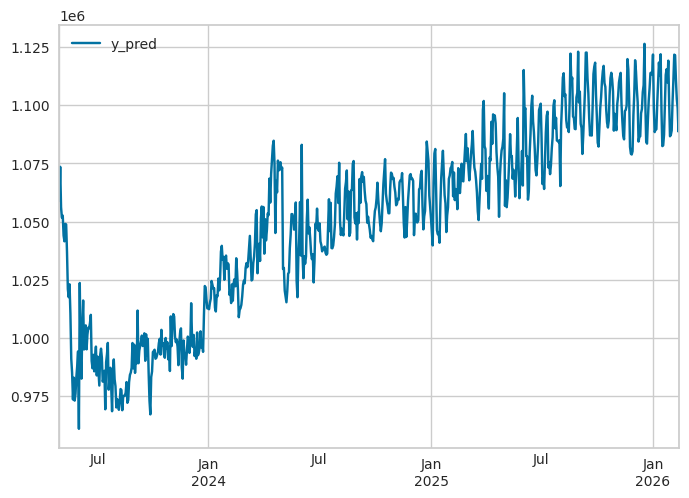

In [95]:
hasil_ts_multi_all = pycaret_mul_time_series_all.predict_model(model_mul_pycaret_all_tuned_finalized,X=future_exog_all,fh=730,)
hasil_ts_multi_all.plot()

In [96]:
hasil_ts_multi_all.rename(columns={'y_pred':'harga_emas'},inplace=True)

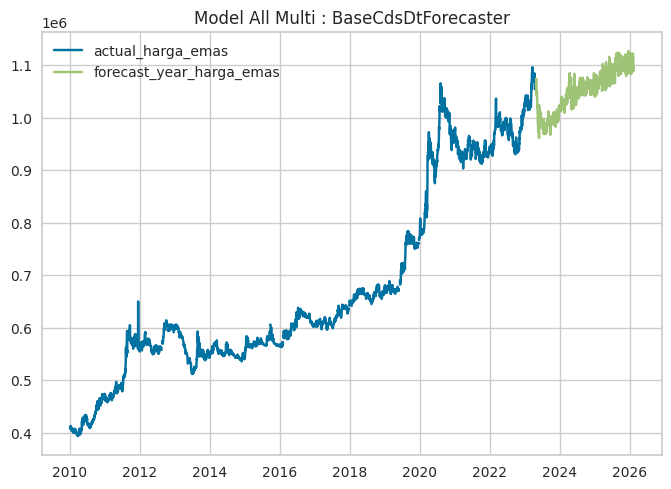

In [97]:
try:
    nama_model_multi_all = model_mul_pycaret_all_tuned_finalized.get_params()['forecaster__model'].__class__.__name__
except:
    nama_model_multi_all = ''
    pass
    
plt.plot(tabel_emas_mul_pycaret_all.index,tabel_emas_mul_pycaret_all.harga_emas,label='actual_harga_emas')
plt.plot(hasil_ts_multi_all.index,hasil_ts_multi_all.harga_emas,label='forecast_year_harga_emas')
plt.title(f'Model All Multi : {nama_model_multi_all}')
plt.legend()
plt.show()

# Pycaret Multi Prophet

In [98]:
from pycaret.time_series import *

tabel_emas_mul_pycaret_all_prophet = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_mul_pycaret_all_prophet.tanggal = pd.to_datetime(tabel_emas_mul_pycaret_all_prophet.tanggal)
tanggal_tabel_emas_mul_pycaret_all = pd.date_range(tabel_emas_mul_pycaret_all_prophet.tanggal[0],
                                              tabel_emas_mul_pycaret_all_prophet.tanggal[tabel_emas_mul_pycaret_all_prophet.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_mul_pycaret_all_prophet = pd.DataFrame(index=tanggal_tabel_emas_mul_pycaret_all)
tanggal_tabel_emas_mul_pycaret_all_prophet.index.name = 'tanggal'

tabel_emas_mul_pycaret_all_prophet = tabel_emas_mul_pycaret_all_prophet.set_index('tanggal')
tabel_emas_mul_pycaret_all_prophet = tanggal_tabel_emas_mul_pycaret_all_prophet.merge(tabel_emas_mul_pycaret_all_prophet,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )

# idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
# tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)
# knnimp = KNNImputer()

# kol_tab_pyc = tabel_emas_pycaret.columns.tolist()
# tabel_emas_pycaret = knnimp.fit_transform(tabel_emas_pycaret)
# tabel_emas_pycaret = pd.DataFrame(tabel_emas_pycaret,columns=kol_tab_pyc)
# tabel_emas_pycaret = tabel_emas_pycaret.set_index(idx)
# tabel_emas_pycaret.plot()

print(100*'=')
display(tabel_emas_mul_pycaret_all_prophet.describe())
display(tabel_emas_mul_pycaret_all_prophet.head())


pycaret_time_series_all_prophet = TSForecastingExperiment()
pycaret_time_series_all_prophet.setup(data=tabel_emas_mul_pycaret_all_prophet,session_id=42,
            target='harga_emas',
            numeric_imputation_target='drift',
            numeric_imputation_exogenous='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            #transform_target="box-cox",
            #transform_exogenous="box-cox",
            fold=3,
            fh=730)


pycaret_time_series_all_prophet.check_stats()

,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
count,3.283000e+03,3255.000000,3255.000000,3261.000000,3283.000000
mean,6.755510e+05,12573.204479,12448.059757,0.043027,5.640344
std,1.798187e+05,2233.047140,2210.835988,0.018552,1.320357
min,3.940000e+05,8502.000000,8418.000000,0.013200,3.500000
25%,5.605000e+05,9789.000000,9691.000000,0.031300,4.500000
50%,6.070000e+05,13405.000000,13271.000000,0.039700,5.750000
75%,7.830000e+05,14330.800000,14188.350000,0.055700,6.750000
max,1.096000e+06,16824.710000,16657.300000,0.087900,7.750000


,harga_emas,kurs_jual,kurs_beli,data_inflasi,suku_bunga_bi
tanggal,,,,,
2010-01-04,408000.0,9377.0,9283.0,0.0372,6.5
2010-01-05,410000.0,9355.0,9261.0,0.0372,6.5
2010-01-06,410000.0,9355.0,9261.0,0.0372,6.5
2010-01-07,412000.0,9274.0,9182.0,0.0372,6.5
2010-01-08,410000.0,9286.0,9194.0,0.0372,6.5


,Description,Value
0,session_id,42
1,Target,harga_emas
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(3475, 5)"
5,Transformed data shape,"(3475, 5)"
6,Transformed train set shape,"(2745, 5)"
7,Transformed test set shape,"(730, 5)"
8,Rows with missing values,6.9%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3475.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,674525.248148
3,Summary,Statistics,Transformed,Median,,608870.99531
4,Summary,Statistics,Transformed,Standard Deviation,,178454.921414
5,Summary,Statistics,Transformed,Variance,,31846158976.722122
6,Summary,Statistics,Transformed,Kurtosis,,-0.703589
7,Summary,Statistics,Transformed,Skewness,,0.710449
8,Summary,Statistics,Transformed,# Distinct Values,,770.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",79811.537083


In [99]:
model_pycaret_all_prophet =  pycaret_time_series_all_prophet.create_model('xgboost_cds_dt')
model_pycaret_all_prophet

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012-02-17,1.5859,1.7469,143891.3554,167940.7357,0.2605,0.2216,-53.5882
1,2014-12-05,0.2743,0.2764,14053.2894,17628.3286,0.0234,0.0237,0.4920
2,2017-09-22,1.3192,1.6341,53324.0358,85810.0460,0.0658,0.0712,-0.0311
Mean,NaT,1.0598,1.2191,70422.8936,90459.7034,0.1166,0.1055,-17.7091
SD,NaT,0.5660,0.6682,54367.6316,61452.7972,0.1033,0.0844,25.3713


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [261,
                                                                        260,
                                                                        259,
                                                                        258,
                                                                        257,
                                                                        256,
                                                                        255,
                                                                        254,
                                                                        253,
                                                                        252,
                                                                        251,
                                                                        250,
                                                                        249,
                                                                        248,
                                                                        247,
                                                                        246,
                                                                        245,
                                                                        244,
                                                                        243,
                                                                        242,
                                                                        241,
                                                                        240,
                                                                        239,
                                                                        238,
                                                                        237,
                                                                        236,
                                                                        235,
                                                                        234,
                                                                        233,
                                                                        232, ...]},
                                                   n_jobs=1)],
                    regressor=XGBRegressor(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           earl...
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                    sp=261, window_length=261)

In [100]:
model_pycaret_all_prophet.get_params()['regressor'].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [ ]:
tuned_model_pycaret_all_prophet =  pycaret_time_series_all_prophet.tune_model(model_pycaret_all_prophet)
display(tuned_model_pycaret_all_prophet)
model_pycaret_prophet_uni.get_params()['regressor'].get_params()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,06:52:38
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting w/ Cond. Deseasonali...


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
pycaret_time_series_all_prophet.plot_model(tuned_model_pycaret_all_prophet)

In [ ]:
final_tuned_model_pycaret_all_prophet =  pycaret_time_series_all_prophet.finalize_model(tuned_model_pycaret_all_prophet)
final_tuned_model_pycaret_all_prophet

## Pycaret All prophet

In [ ]:
kolom_exo = tabel_emas_mul_pycaret_all_prophet.columns.tolist()
kolom_exo.remove('harga_emas')

exog_exps = []
exog_models = []
for exog_var in kolom_exo:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=tabel_emas_mul_pycaret_all_prophet[exog_var], fh=730,
        numeric_imputation_target="drift", 
        session_id=42,
        #transform_target="box-cox",
        max_sp_to_consider=None,
        num_sps_to_use=-1,
    )
    display(exog_exp.check_stats())

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    best = exog_exp.create_model("xgboost_cds_dt")
    best = exog_exp.tune_model(best)
    display(best)
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)
    display(exog_exp.check_stats())
    
    
    
# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = kolom_exo
future_exog.head()

In [ ]:
forecast_df_all_prophet = pycaret_time_series_all_prophet.predict_model(final_tuned_model_pycaret_all_prophet,X=future_exog,fh=730,)
forecast_df_all_prophet

In [ ]:
forecast_df_all_prophet.index = forecast_df_all_prophet.index.strftime('%Y-%m-%d')
forecast_df_all_prophet.plot()

In [ ]:
forecast_df_all_prophet.columns = ['harga_emas']
forecast_df_all_prophet

In [ ]:
future_exog.index = future_exog.index.strftime('%Y-%m-%d')
future_exog.index

In [ ]:
hasil_forecast_all_prophet = pd.merge(forecast_df_all_prophet, future_exog, left_index=True, right_index=True)
hasil_forecast_all_prophet

In [ ]:
hasil_forecast_all_prophet.plot()

In [ ]:
hasil_forecast_all_prophet.index = pd.PeriodIndex(hasil_forecast_all_prophet.index,freq='B')
hasil_forecast_all_prophet

In [ ]:
hasil_forecast_all_prophet.plot()

In [ ]:
hasil_tabel_emas_pycaret_all_prophet = pd.concat([tabel_emas_mul_pycaret_all_prophet,hasil_forecast_all_prophet])
hasil_tabel_emas_pycaret_all_prophet

In [ ]:
hasil_tabel_emas_pycaret_all_prophet.plot()

In [ ]:
hasil_forecast_all_prophet

In [ ]:
plt.plot(tabel_emas_mul_pycaret_all_prophet.index.to_period().to_timestamp(),tabel_emas_mul_pycaret_all_prophet.harga_emas,label="Data Actual")
plt.plot(hasil_forecast_all_prophet.index.to_timestamp(),hasil_forecast_all_prophet.harga_emas,label="forecast_All_Prophet")
plt.title('Model XGBoost Multivariate')
plt.legend()
plt.show()

In [ ]:
tabel_emas_mul_pycaret_all_prophet

In [ ]:
hasil_forecast_all_prophet.to_csv('Hasil_Forecasting_XGBoost.csv')